In [2192]:
import time
from typing import Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy

In [2193]:
# import gdown
# import os

# def load(id, filename):
#   if not os.path.isfile(filename):
#     gdown.download(id=id, output=filename)

# load('1-C0k7nEYTUjBJdO1MXkSUc_aH7lG69Fr', 'train.csv')
# load('1W09ak2hdA9tfn4nF3KNQAJgaOy9HTF2w', 'test.csv')
# load('1le8Fjzp-QOG2177GDcdhyuTxxbJ6vTsj', 'ex.csv')

In [2194]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Вспомогательные функции

### Визуализация

In [2195]:
def show_dependency(df, xcol, ycol):
  corr_matrix = df[[xcol, ycol]].corr()
  x = df[xcol]
  y = df[ycol]
  p = np.poly1d(np.polyfit(x, y, 1))
  plt.scatter(x, y, alpha=0.5)
  plt.ylim(np.min(plt.yticks()[0]), np.max(plt.yticks()[0]))
  plt.plot(x, p(x), "r--")
  plt.scatter([], [], alpha=0, label=f'Корреляция: {corr_matrix[xcol][ycol]:.3f}')
  plt.xlabel(xcol)
  plt.ylabel(ycol)
  plt.title(f'Зависимость {ycol} от {xcol}')
  plt.grid(True)
  plt.legend()
  plt.show()

In [2196]:
def show_corr_matrix(df, min_corr = 0, annot = False, dropTarget = True, fmt='.2g', figsize=(12, 6), grid=False):
  if dropTarget:
    df = df.drop(columns='RiskScore', errors='ignore')
  corr_matrix = df.corr()
  plt.figure(figsize=figsize)
  sns.heatmap(corr_matrix[corr_matrix.abs() > min_corr], cmap='coolwarm', vmin=-1, vmax=1, annot=annot, fmt=fmt)
  plt.title("Корреляционная матрица")
  plt.grid(grid)
  plt.show()

def show_corr_column(df, column, min_corr = 0, annot = False, dropTarget = True, fmt='.2g', figsize=(8, 6), grid=False):
  if dropTarget:
    df = df.drop(columns='RiskScore', errors='ignore')
  corr_column = df.corrwith(df[column]).drop(index=column)
  corr_column = corr_column[corr_column.abs() > min_corr]
  plt.figure(figsize=figsize)
  sns.heatmap(corr_column.values.reshape(-1, 1), xticklabels=[column], yticklabels=corr_column.index,
              cmap='coolwarm', vmin=-1, vmax=1, annot=annot, fmt=fmt)
  plt.title("Корреляционная матрица")
  plt.grid(grid)
  plt.show()

In [2197]:
def build_distribution(values, column):
  sns.kdeplot(values, fill=True, cut=0)
  plt.plot([values.mean(), values.mean()], [0, np.max(plt.yticks()[0])], label='Средее')
  plt.scatter([], [], alpha=0, label=f'Асимметрия: {scipy.stats.skew(values):.3f}')
  plt.scatter([], [], alpha=0, label=f'Эксцесс: {scipy.stats.kurtosis(values):.3f}')
  plt.title(f'Плотность {column}')
  plt.legend()

def show_distribution(df, column):
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  build_distribution(df[column], column)
  plt.subplot(1, 2, 2)
  plt.boxplot(df[column], tick_labels=[column])
  plt.title(f'Размах {column}')
  plt.show()

def show_distributions(df, columns):
  cnt = len(columns)
  rows = (cnt + 1) // 2
  plt.figure(figsize=(13, 6 * rows))
  for i in range(len(columns)):
    plt.subplot(rows, 2, i + 1)
    build_distribution(df[columns[i]], columns[i])
  plt.show()

def compare_distribution(df, left_column, right_column):
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  build_distribution(df[left_column], left_column)
  plt.subplot(1, 2, 2)
  build_distribution(df[right_column], right_column)
  plt.show()

### Преобразование признаков

In [2198]:
def boxcox_transform(df, l):
  if l == 0:
    return np.log(df)
  return (df ** l - 1) / l

# Подготовка данных

### Выделение числовых и категориальных признаков

In [2199]:
train_data.head()

ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                562.0   

   ...  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0  ...          Employed       Associate         4.0   35067.0   
1  ...          Employed     High School        33.0   27001.0   
2  ...          Employed        Bachelor        28.0  278382.0   
3  ...          Employed     High School         0.0    9224.0   
4  ...          Employed        Bachelor        31.0    4502.0   

   BaseInterestRate InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.257790     0.251465          508.970230                0.288013   
1          0.086110     0.093173          514.675859                0.050585   
2          0.108436     0.115443         1268.276385                0.072571   
3          0.100686     0.112822          498.505187                0.225415   
4          0.110437     0.089037          756.035156                0.052721   

   LoanApproved  RiskScore  
0           0.0  66.176500  
1           1.0  28.495737  
2           1.0  34.488104  
3           1.0  36.910753  
4           1.0  31.347091  

[5 rows x 36 columns]

In [2200]:
numeric_features = train_data.drop(columns='RiskScore').select_dtypes(np.number).columns
numeric_features

Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate',
       'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio',
       'LoanApproved'],
      dtype='object')

In [2201]:
categorical_features = train_data.drop(columns='RiskScore').select_dtypes(object).columns
categorical_features

Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')

### Заполнение пропусков

Заполним пропуски в тренировочной выборке.

In [2202]:
train_data['RiskScore'].isna().agg({'NA count': 'sum', 'NA rate': 'mean'})

NA count    530.000000
NA rate       0.048107
Name: RiskScore, dtype: float64

Пропуски в целевом признаке составляют всего ~5%, так что строки с ними можно просто удалить.

In [2203]:
train_data.dropna(subset=['RiskScore'], axis='rows', inplace=True)

In [2204]:
pd.DataFrame({'NA count': train_data.isna().sum(), 'NA rate': train_data.isna().mean()})

NA count   NA rate
ApplicationDate                    0  0.000000
Age                                0  0.000000
AnnualIncome                       0  0.000000
CreditScore                      501  0.047773
LoanAmount                       501  0.047773
LoanDuration                       0  0.000000
MaritalStatus                      0  0.000000
NumberOfDependents                 0  0.000000
HomeOwnershipStatus                0  0.000000
MonthlyDebtPayments              501  0.047773
CreditCardUtilizationRate          0  0.000000
NumberOfOpenCreditLines            0  0.000000
NumberOfCreditInquiries            0  0.000000
DebtToIncomeRatio                  0  0.000000
BankruptcyHistory                501  0.047773
LoanPurpose                      501  0.047773
PreviousLoanDefaults               0  0.000000
PaymentHistory                     0  0.000000
LengthOfCreditHistory              0  0.000000
SavingsAccountBalance              0  0.000000
CheckingAccountBalance           501  0.047773
TotalAssets                      501  0.047773
TotalLiabilities                   0  0.000000
MonthlyIncome                      0  0.000000
UtilityBillsPaymentHistory         0  0.000000
JobTenure                          0  0.000000
EmploymentStatus                   0  0.000000
EducationLevel                     0  0.000000
Experience                         0  0.000000
NetWorth                         501  0.047773
BaseInterestRate                 501  0.047773
InterestRate                       0  0.000000
MonthlyLoanPayment                 0  0.000000
TotalDebtToIncomeRatio             0  0.000000
LoanApproved                       0  0.000000
RiskScore                          0  0.000000

Оставшиеся пропуски в числовых признаках заполним средним значением, а в категориальных &ndash; модальным.

In [2205]:
train_data[numeric_features] = train_data[numeric_features].fillna(train_data[numeric_features].mean())

In [2206]:
for feat in categorical_features:
  train_data[feat] = train_data[feat].fillna(train_data[feat].mode()[0])

In [2207]:
pd.DataFrame({'NA count': train_data.isna().sum()})

NA count
ApplicationDate                    0
Age                                0
AnnualIncome                       0
CreditScore                        0
LoanAmount                         0
LoanDuration                       0
MaritalStatus                      0
NumberOfDependents                 0
HomeOwnershipStatus                0
MonthlyDebtPayments                0
CreditCardUtilizationRate          0
NumberOfOpenCreditLines            0
NumberOfCreditInquiries            0
DebtToIncomeRatio                  0
BankruptcyHistory                  0
LoanPurpose                        0
PreviousLoanDefaults               0
PaymentHistory                     0
LengthOfCreditHistory              0
SavingsAccountBalance              0
CheckingAccountBalance             0
TotalAssets                        0
TotalLiabilities                   0
MonthlyIncome                      0
UtilityBillsPaymentHistory         0
JobTenure                          0
EmploymentStatus                   0
EducationLevel                     0
Experience                         0
NetWorth                           0
BaseInterestRate                   0
InterestRate                       0
MonthlyLoanPayment                 0
TotalDebtToIncomeRatio             0
LoanApproved                       0
RiskScore                          0

В тестовой выборке пропуски отсутствуют.

In [2208]:
pd.DataFrame({'NA count': test_data.isna().sum()})

NA count
ID                                 0
ApplicationDate                    0
Age                                0
AnnualIncome                       0
CreditScore                        0
LoanAmount                         0
LoanDuration                       0
MaritalStatus                      0
NumberOfDependents                 0
HomeOwnershipStatus                0
MonthlyDebtPayments                0
CreditCardUtilizationRate          0
NumberOfOpenCreditLines            0
NumberOfCreditInquiries            0
DebtToIncomeRatio                  0
BankruptcyHistory                  0
LoanPurpose                        0
PreviousLoanDefaults               0
PaymentHistory                     0
LengthOfCreditHistory              0
SavingsAccountBalance              0
CheckingAccountBalance             0
TotalAssets                        0
TotalLiabilities                   0
MonthlyIncome                      0
UtilityBillsPaymentHistory         0
JobTenure                          0
EmploymentStatus                   0
EducationLevel                     0
Experience                         0
NetWorth                           0
BaseInterestRate                   0
InterestRate                       0
MonthlyLoanPayment                 0
TotalDebtToIncomeRatio             0
LoanApproved                       0

### Удаление дубликатов

In [2209]:
train_data.shape

(10487, 36)

In [2210]:
train_data = train_data.drop_duplicates()
train_data.shape

(10000, 36)

### Обработка категориальных признаков

Рассмотрим области значений категориальных признаков.

In [2211]:
train_data[categorical_features].nunique()

ApplicationDate        10000
MaritalStatus              4
HomeOwnershipStatus        4
LoanPurpose                5
EmploymentStatus           3
EducationLevel             5
dtype: int64

In [2212]:
train_data['ApplicationDate'][0]

'2010-06-26'

In [2213]:
print(f"MaritalStatus: {np.unique(train_data['MaritalStatus'].values)}")
print(f"HomeOwnershipStatus: {np.unique(train_data['HomeOwnershipStatus'].values)}")
print(f"LoanPurpose: {np.unique(train_data['LoanPurpose'].values)}")
print(f"EmploymentStatus: {np.unique(train_data['EmploymentStatus'].values)}")
print(f"EducationLevel: {np.unique(train_data['EducationLevel'].values)}")

MaritalStatus: ['Divorced' 'Married' 'Single' 'Widowed']
HomeOwnershipStatus: ['Mortgage' 'Other' 'Own' 'Rent']
LoanPurpose: ['Auto' 'Debt Consolidation' 'Education' 'Home' 'Other']
EmploymentStatus: ['Employed' 'Self-Employed' 'Unemployed']
EducationLevel: ['Associate' 'Bachelor' 'Doctorate' 'High School' 'Master']


Признак ApplicationDate можно привести к типу date и разбить на год, месяц и день. Остальные категориальные признаки имеют небольшое количество возможных значений, поэтому к ним можно применить one-hot encoding.

In [2214]:
def deconstruct_application_date(df):
  df2 = df.copy()
  df2['ApplicationDate']  = pd.to_datetime(df2['ApplicationDate'], format='%Y-%m-%d')
  df2['ApplicationYear']  = df2['ApplicationDate'].dt.year
  df2['ApplicationMonth'] = df2['ApplicationDate'].dt.month
  df2['ApplicationDay']   = df2['ApplicationDate'].dt.day
  df2.drop(columns=['ApplicationDate'], inplace=True)
  return df2

train_data = deconstruct_application_date(train_data)
test_data  = deconstruct_application_date(test_data)

One-hot encoding:

In [2215]:
def one_hot_encode(df, feature_list):
  df2 = df.copy()
  for i in range(0, len(feature_list)):
    values = np.unique(df2[feature_list[i]].values)
    for j in range(0, max(1, len(values) - 1)):
      formatted = ''.join(ch for ch in values[j] if ch.isalpha())
      new_feat = feature_list[i] + formatted
      df2[new_feat] = df2[feature_list[i]] == values[j]
      df2[new_feat] = df2[new_feat].astype(int)
    df2.drop(columns=feature_list[i], inplace=True)
  return df2

f = list(categorical_features)
f.remove('ApplicationDate')

train_data = one_hot_encode(train_data, f)
test_data  = one_hot_encode(test_data, f)

### Обработка выбросов целевого параметра

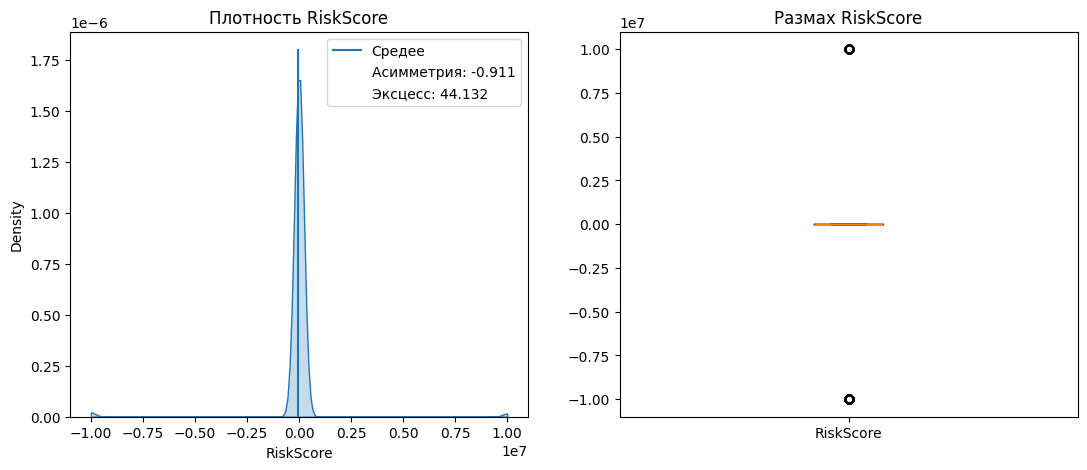

In [2216]:
show_distribution(train_data, 'RiskScore')

In [2217]:
train_data[train_data['RiskScore'] > 100]['RiskScore'].sort_values()

237     10000000.0
398     10000000.0
657     10000000.0
1168    10000000.0
1253    10000000.0
           ...    
9734    10000000.0
9762    10000000.0
9764    10000000.0
9791    10000000.0
9929    10000000.0
Name: RiskScore, Length: 91, dtype: float64

In [2218]:
train_data[train_data['RiskScore'] < 0]['RiskScore'].sort_values()

33     -9999999.0
56     -9999999.0
83     -9999999.0
183    -9999999.0
198    -9999999.0
          ...    
9148   -9999999.0
9263   -9999999.0
9710   -9999999.0
9959   -9999999.0
9987   -9999999.0
Name: RiskScore, Length: 121, dtype: float64

Найденные выбросы равны либо 10000000, либо -9999999, тогда как все остальные значения RiskScore распределены между 0 и 100. Так что эти значения &ndash; ошибки или заглушки, которые нужно удалить.



In [2219]:
train_data.drop(train_data[train_data['RiskScore'] < 0].index, inplace=True)
train_data.drop(train_data[train_data['RiskScore'] > 100].index, inplace=True)

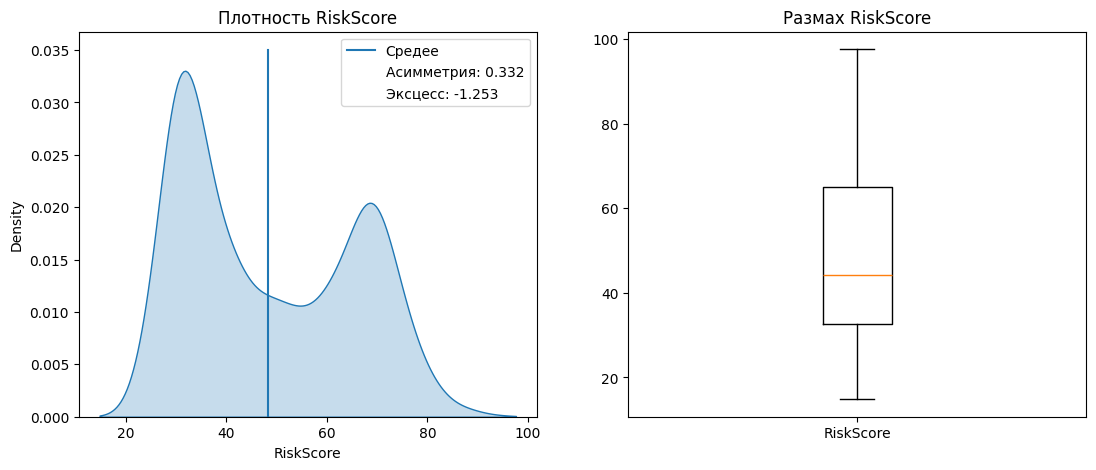

In [2220]:
show_distribution(train_data, 'RiskScore')

# Обработка данных

In [2221]:
tf_train_data = train_data.copy()
tf_test_data = test_data.copy()

### Исследование мультиколлинеарности

Построим корреляционную матрицу, чтобы изучить зависимости между признаками.

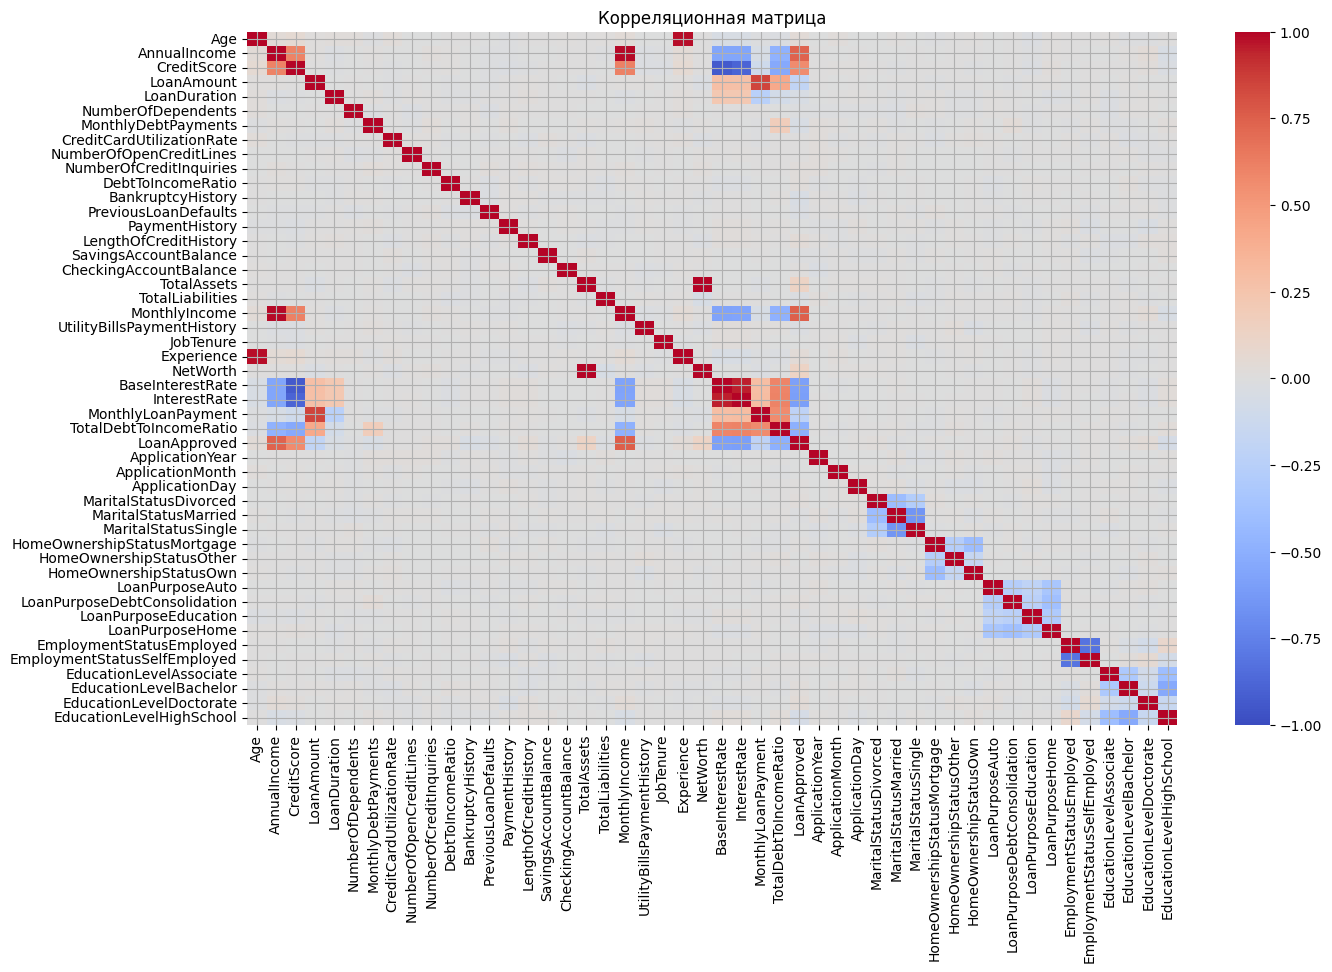

In [2222]:
show_corr_matrix(tf_train_data, figsize=(15,9), grid=True)

Примеры практического отсутствия корреляции корреляции ($|c| < 0.05$).

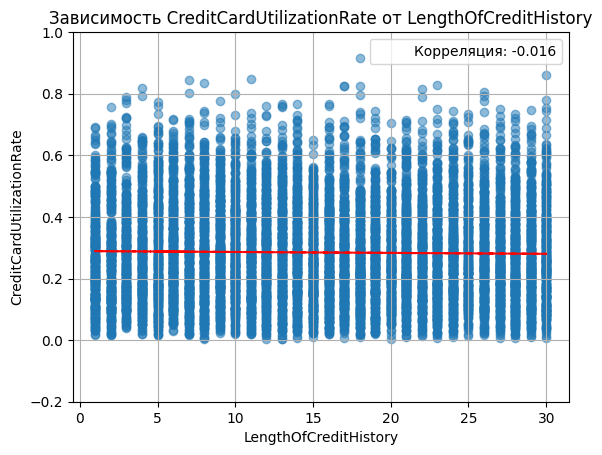

In [2223]:
show_dependency(train_data, 'LengthOfCreditHistory', 'CreditCardUtilizationRate')

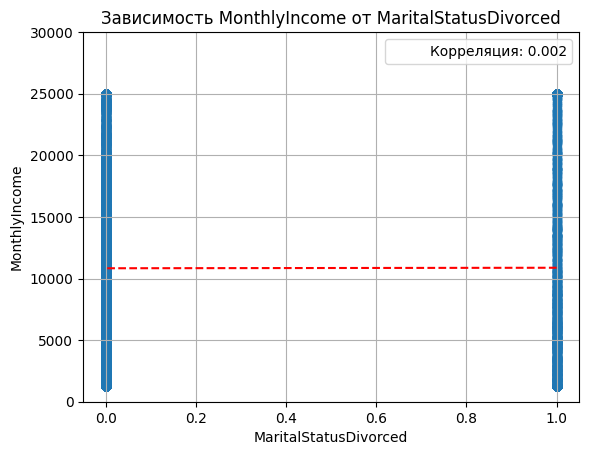

In [2224]:
show_dependency(train_data, 'MaritalStatusDivorced', 'MonthlyIncome')

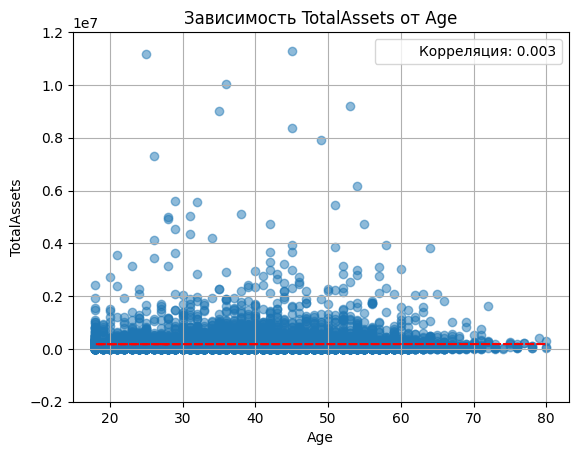

In [2225]:
show_dependency(train_data, 'Age', 'TotalAssets')

Примеры слабой корреляции ($0.05 \leq |c| < 0.3$).

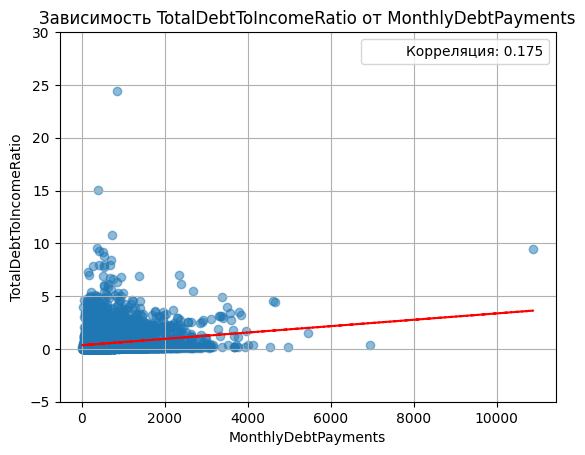

In [2226]:
show_dependency(train_data, 'MonthlyDebtPayments', 'TotalDebtToIncomeRatio')

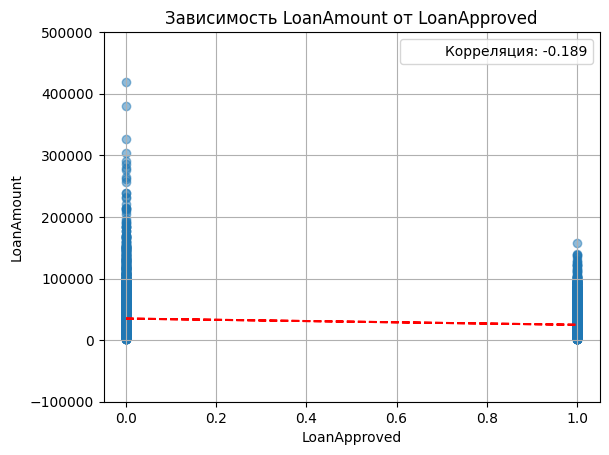

In [2227]:
show_dependency(train_data, 'LoanApproved', 'LoanAmount')

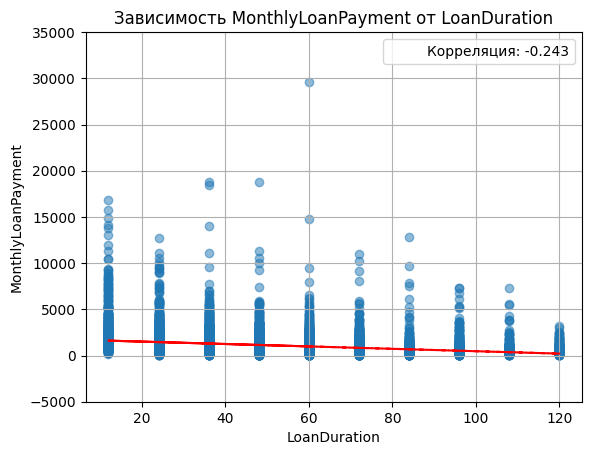

In [2228]:
show_dependency(train_data, 'LoanDuration', 'MonthlyLoanPayment')

Примеры средней корреляции ($0.3 \leq |c| < 0.7$).

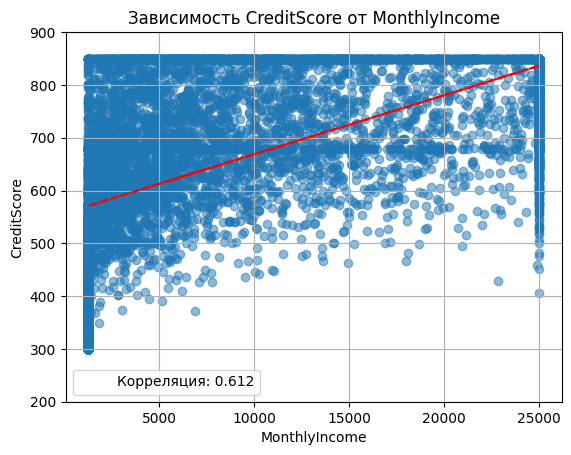

In [2229]:
show_dependency(train_data, 'MonthlyIncome', 'CreditScore')

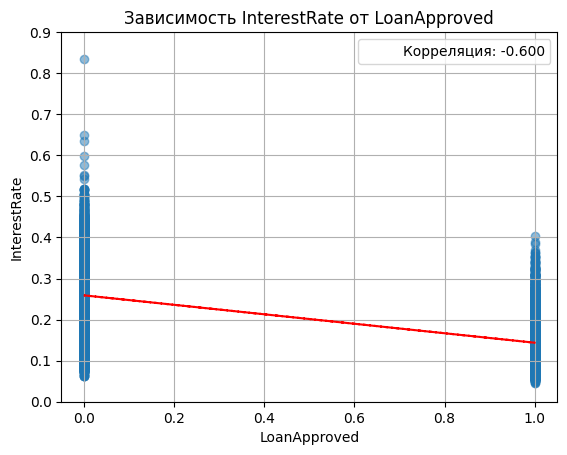

In [2230]:
show_dependency(train_data, 'LoanApproved', 'InterestRate')

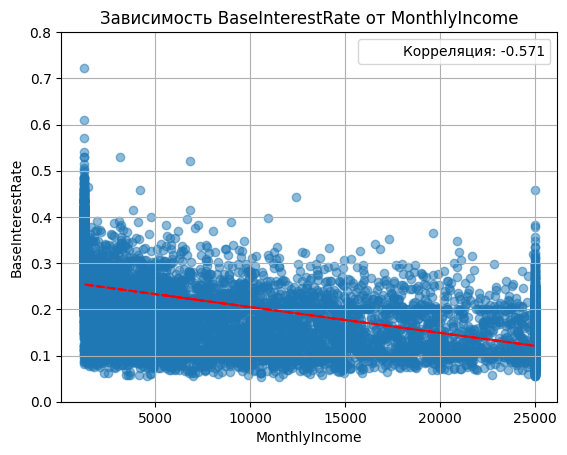

In [2231]:
show_dependency(train_data, 'MonthlyIncome', 'BaseInterestRate')

Примеры сильной корреляции ($|c| \geq 0.7$).

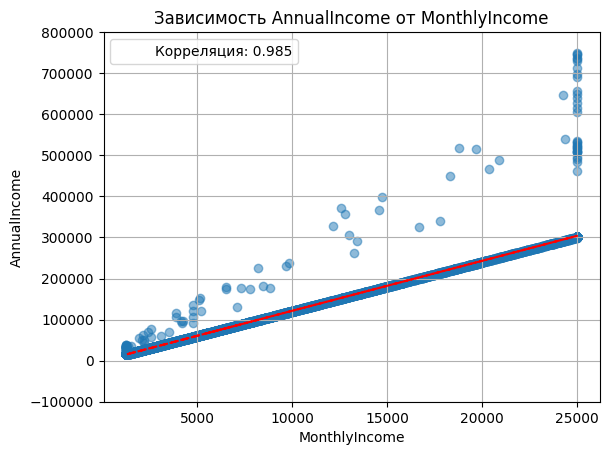

In [2232]:
show_dependency(train_data, 'MonthlyIncome', 'AnnualIncome')

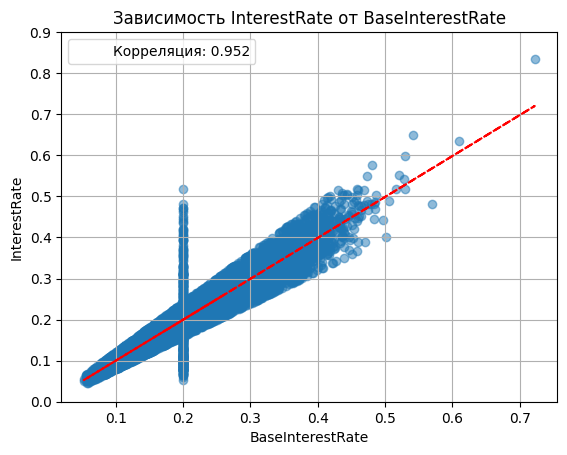

In [2233]:
show_dependency(train_data, 'BaseInterestRate', 'InterestRate')

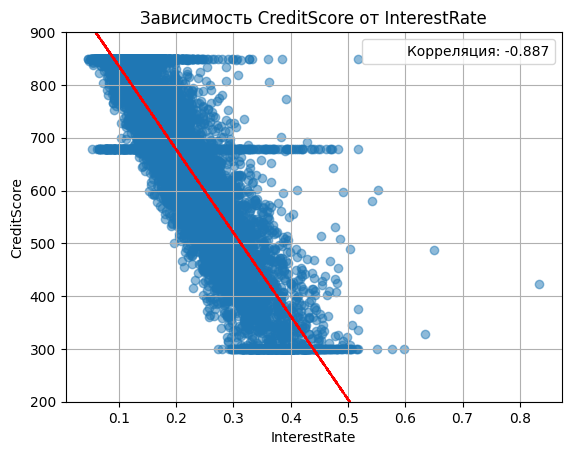

In [2234]:
show_dependency(train_data, 'InterestRate', 'CreditScore')

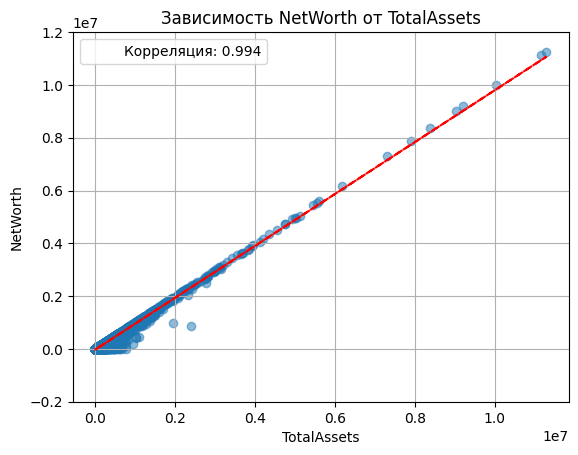

In [2235]:
show_dependency(train_data, 'TotalAssets', 'NetWorth')

### Разрешение мультиколлинеарности родственных признаков

Выделим из корреляционной матрицы признаки, имеющие хотя бы один коэффициент корреляции по модулю больший, чем 0.7, и посмотрим как для некоторых из них можно разрешить проблему коллинеарности.

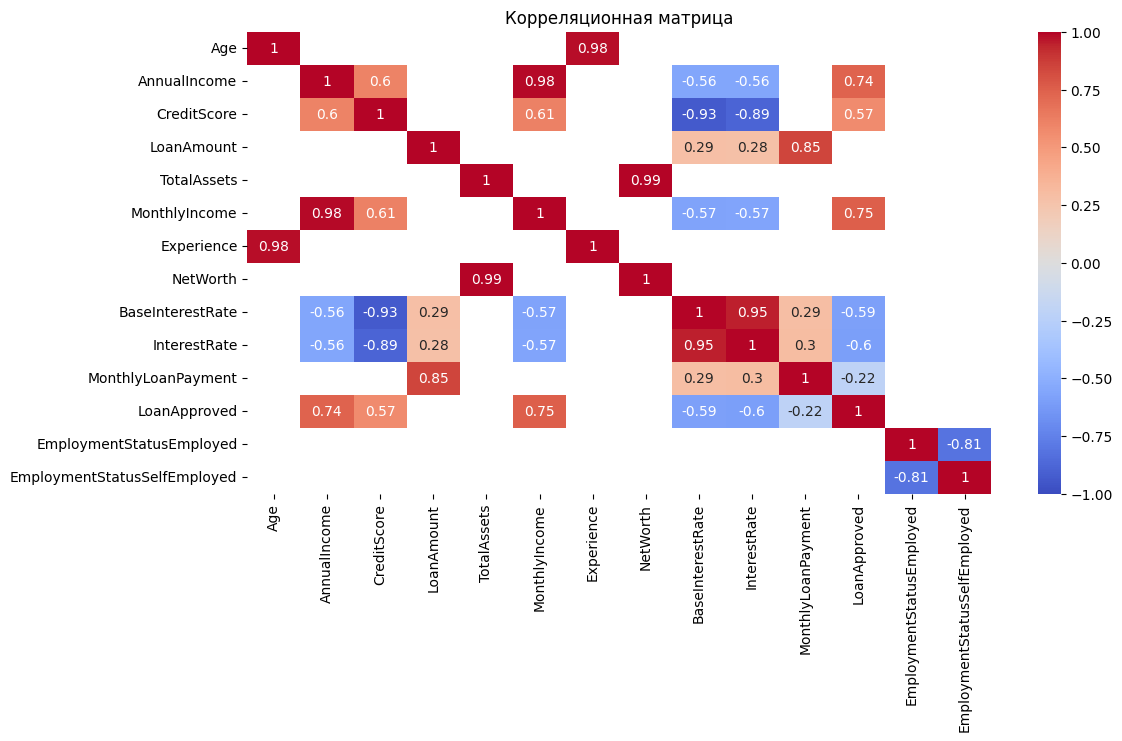

In [2236]:
corr_matrix = tf_train_data.drop(columns='RiskScore', errors='ignore').corr()
columns = corr_matrix.columns

max_corr = np.empty(len(columns))

for i in range(0, len(columns)):
  tmp = corr_matrix[columns[i]].abs().values
  tmp = tmp[np.where(tmp < 1)]
  max_corr[i] = tmp.max()

weak_corr_columns = columns[np.where(max_corr < 0.7)]
show_corr_matrix(tf_train_data.drop(columns=weak_corr_columns), min_corr=0.2, annot=True)

Для возраста и опыта работы (Age и Experience) можно вычислить разность, т.е. количество лет без работы. Также вычислим сумму этих признаков.

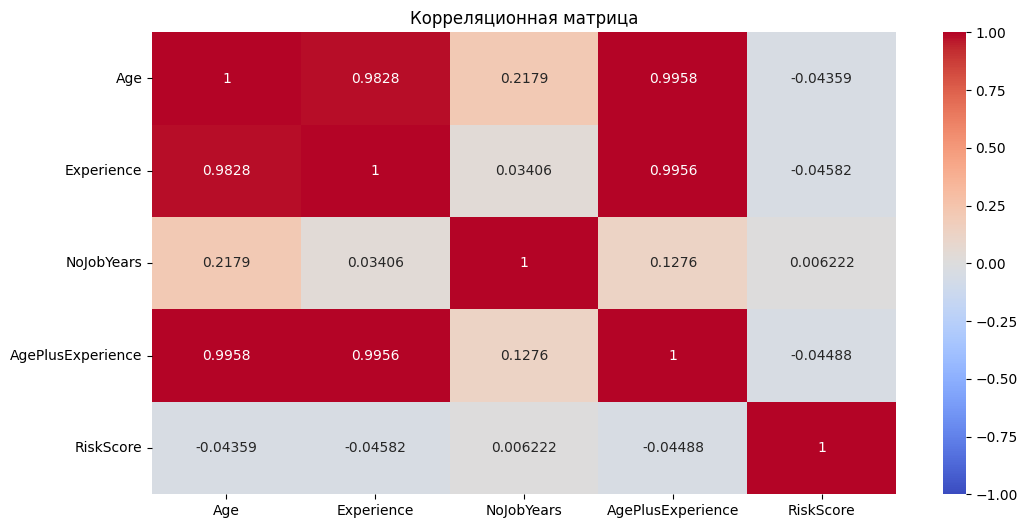

In [2237]:
df = tf_train_data.copy()
df['NoJobYears'] = df['Age'] - df['Experience']
df['AgePlusExperience'] = df['Age'] + df['Experience']
df = df[['Age', 'Experience', 'NoJobYears', 'AgePlusExperience', 'RiskScore']]
show_corr_matrix(df, annot=True, dropTarget=False, fmt='.4g')

Как показывают данные, из рассмотренных признаков больше всего на оценку риска влияет опыт работы. Оставим в выборке только его.
Заметим также, что количество лет без работы почти не коррелирует с таргетом, а значит одинаковый стаж при разном возрасте вносит практически одинаковый вклад в RiskScore, т.е. напрямую RiskScore от возраста не зависит.

In [2238]:
tf_train_data.drop(columns=['Age'], inplace=True, errors='ignore')
tf_test_data.drop(columns=['Age'], inplace=True, errors='ignore')

Для применяемой и базовой процентных ставок (InterestRate и BaseInterestRate) вычислим разность и сумму.

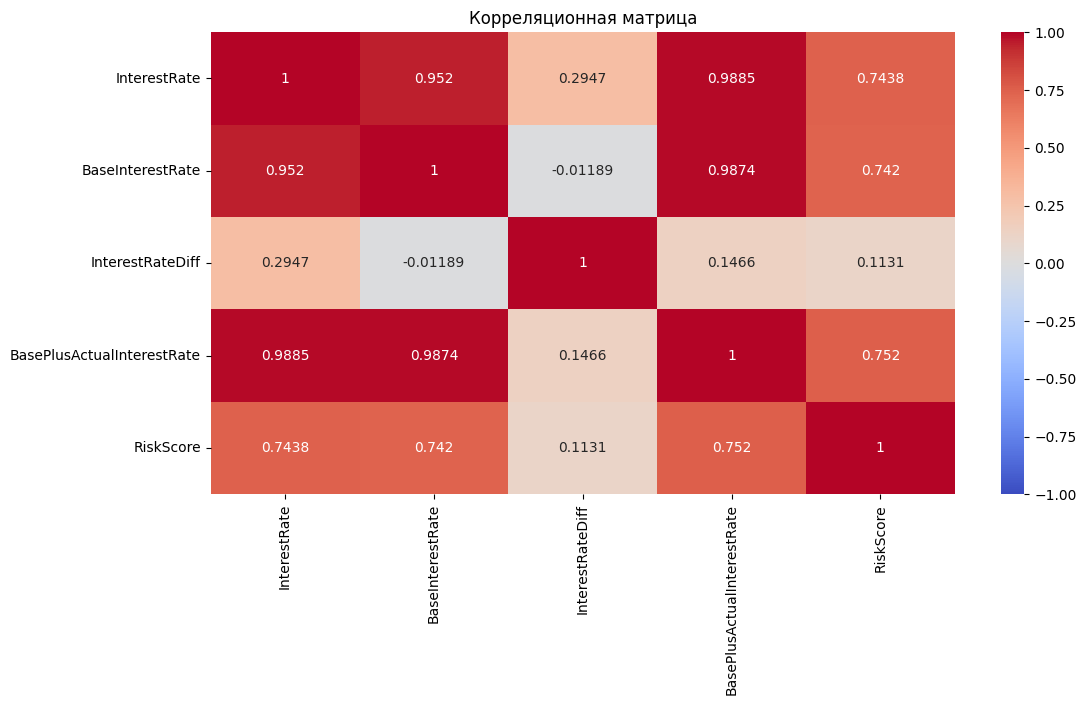

In [2239]:
df = tf_train_data.copy()
df['InterestRateDiff'] = df['InterestRate'] - df['BaseInterestRate']
df['BasePlusActualInterestRate'] = df['InterestRate'] + df['BaseInterestRate']
df = df[['InterestRate', 'BaseInterestRate', 'InterestRateDiff', 'BasePlusActualInterestRate', 'RiskScore']]
show_corr_matrix(df, annot=True, dropTarget=False, fmt='.4g')

Хотя сумма применяемой и базовой процентных ставок не имеет какого-то особого физического смысла, данные показывают, что на оценку риска она влияёт больше всего. Оставим в выборке только её.

In [2240]:
tf_train_data['BasePlusActualInterestRate'] = tf_train_data['InterestRate'] + tf_train_data['BaseInterestRate']
tf_test_data['BasePlusActualInterestRate'] = tf_test_data['InterestRate'] + tf_test_data['BaseInterestRate']
tf_train_data.drop(columns=['InterestRate', 'BaseInterestRate'], inplace=True, errors='ignore')
tf_test_data.drop(columns=['InterestRate', 'BaseInterestRate'], inplace=True, errors='ignore')

Для общей и чистой стоимости активов (TotalAssets и NetWorth) можно вычислить разность, т.е. обязательства клиента по этим активам (Liabilities). Также вычислим сумму этих признаков и проверим отличаются ли вычисленная величина Liabilities от содержащейся в выборке TotalLiabilities.

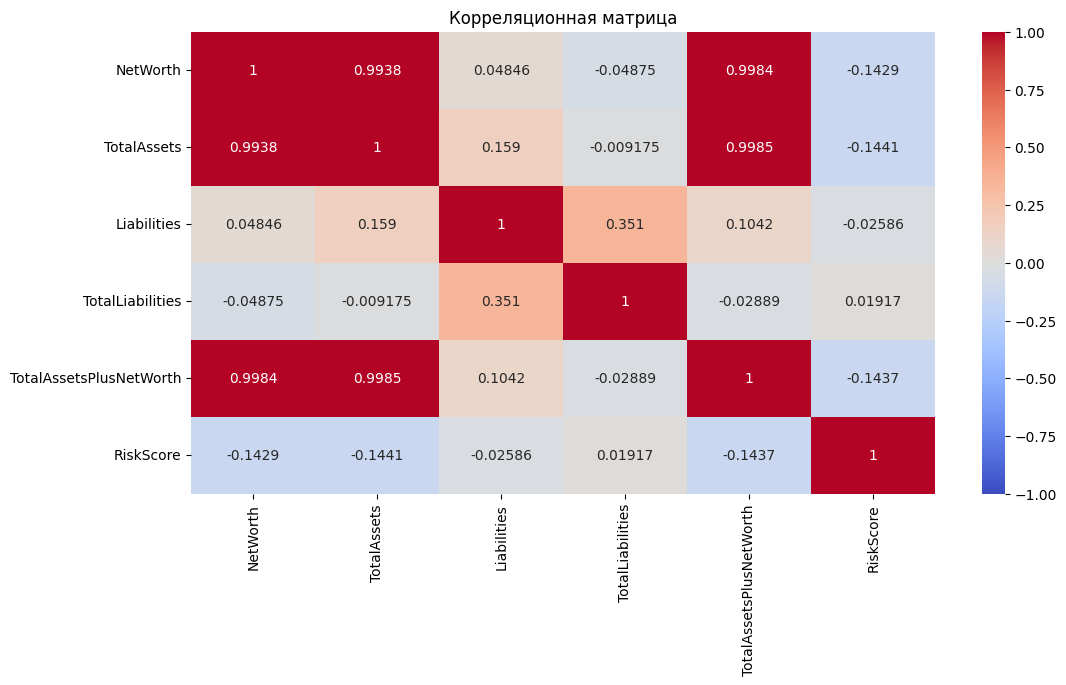

In [2241]:
df = tf_train_data.copy()
df['Liabilities'] = df['TotalAssets'] - df['NetWorth']
df['TotalAssetsPlusNetWorth'] = df['TotalAssets'] + df['NetWorth']
df = df[['NetWorth', 'TotalAssets', 'Liabilities', 'TotalLiabilities', 'TotalAssetsPlusNetWorth', 'RiskScore']]
show_corr_matrix(df, annot=True, dropTarget=False, fmt='.4g')

Судя по корреляции Liabilities и TotalLiabilites, первая является лишь частью второго. Но ни то, ни другое почти не влияет на оценку риска, а из оставшихся величин наибольшую корреляцию с таргетом имеет общая стоимость активов. Оставим в выборке только её.

In [2242]:
tf_train_data.drop(columns=['NetWorth'], inplace=True, errors='ignore')
tf_test_data.drop(columns=['NetWorth'], inplace=True, errors='ignore')

Годовой доход является производной величиной от месячного дохода. Удалим из выборки тот, что меньше коррелирует с целевым параметром.

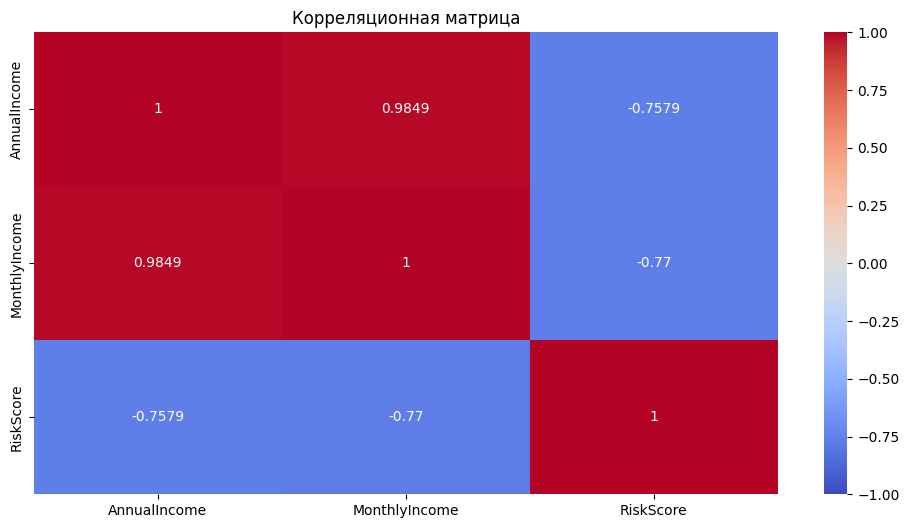

In [2243]:
df = tf_train_data[['AnnualIncome', 'MonthlyIncome', 'RiskScore']]
show_corr_matrix(df, annot=True, dropTarget=False, fmt='.4g')

In [2244]:
tf_train_data.drop(columns=['AnnualIncome'], inplace=True, errors='ignore')
tf_test_data.drop(columns=['AnnualIncome'], inplace=True, errors='ignore')

Из запрашиваемой суммы кредита (LoanAmount) и ежемесячного платежа (MonthlyLoanPayment) можно вычислить длительность погашения без учёта процентов. Проверим так же корреляцию этой величиный с длительностью погашения, учитывающей процент (LoanDuration).

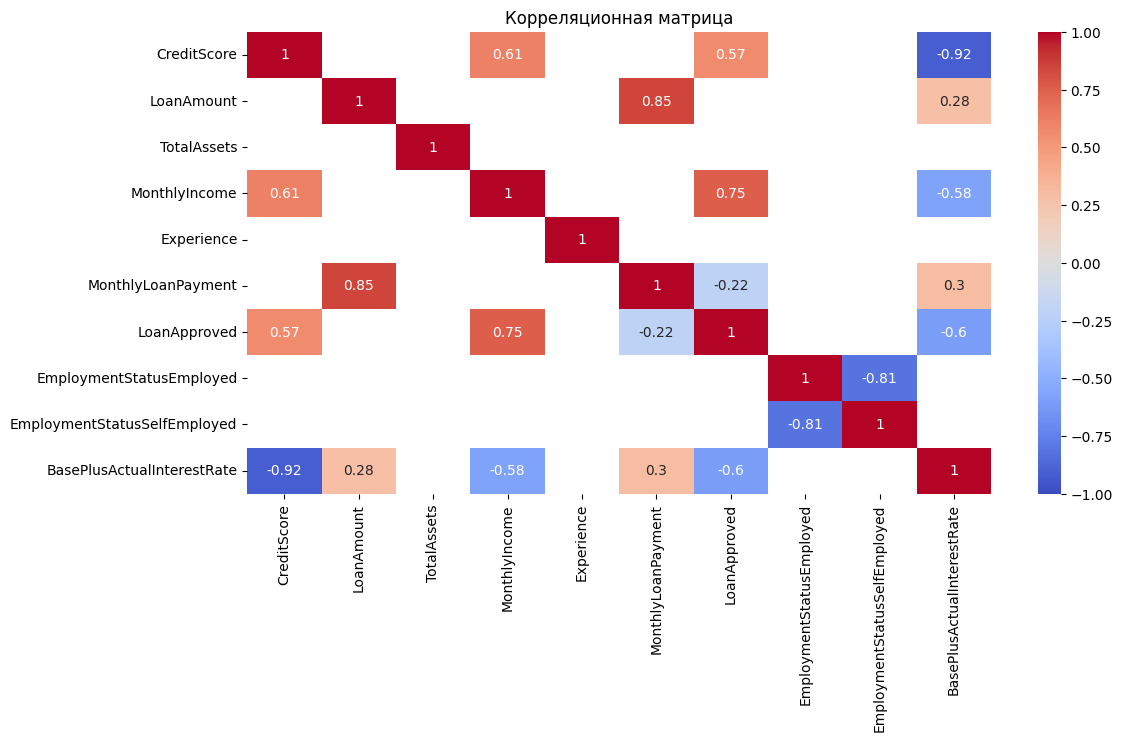

In [2245]:
show_corr_matrix(tf_train_data.drop(columns=weak_corr_columns), min_corr=0.2, annot=True)

### Трансформация распределений признаков

Рассмотрим числовые признаки и их распределения и попытаемся привести его к более "нормальному виду" (Коэффициенты асимметрии и эксцесса у нормального распределения равны 0).

In [2246]:
test_df = tf_train_data.copy()
can_be_stabilized = [
    'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate',
    'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults',
    'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
    'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'MonthlyLoanPayment',
    'TotalDebtToIncomeRatio', 'LoanApproved', 'BasePlusActualInterestRate']

corr = tf_train_data[np.concat((can_be_stabilized, ['RiskScore']))].corr()
corr = corr[corr['RiskScore'].abs() >= 0.000]['RiskScore']
corr.sort_values(key=abs, ascending=False)[1:]

LoanApproved                 -0.871497
MonthlyIncome                -0.769977
CreditScore                  -0.767332
BasePlusActualInterestRate    0.751989
TotalDebtToIncomeRatio        0.551314
BankruptcyHistory             0.175558
MonthlyLoanPayment            0.147029
TotalAssets                  -0.144072
DebtToIncomeRatio             0.110157
LoanAmount                    0.077222
LengthOfCreditHistory        -0.060102
PreviousLoanDefaults          0.054791
CreditCardUtilizationRate     0.053632
Experience                   -0.045816
LoanDuration                  0.028770
UtilityBillsPaymentHistory    0.025609
TotalLiabilities              0.019167
MonthlyDebtPayments           0.017508
NumberOfCreditInquiries      -0.016526
PaymentHistory                0.016511
JobTenure                     0.015130
NumberOfDependents            0.008532
CheckingAccountBalance       -0.007345
NumberOfOpenCreditLines       0.002193
SavingsAccountBalance        -0.001455
Name: RiskScore, dtype: float64

#### Достаточно "нормальные" исходные столбцы

Признаки DebtToIncomeRatio, CreditCardUtilizationRate, Experience, UtilityBillsPaymentHistory и PaymentHistory уже имеют достаточно "нормальное" распределение, а попытки их преобразования привели к ухудшению предсказаний.

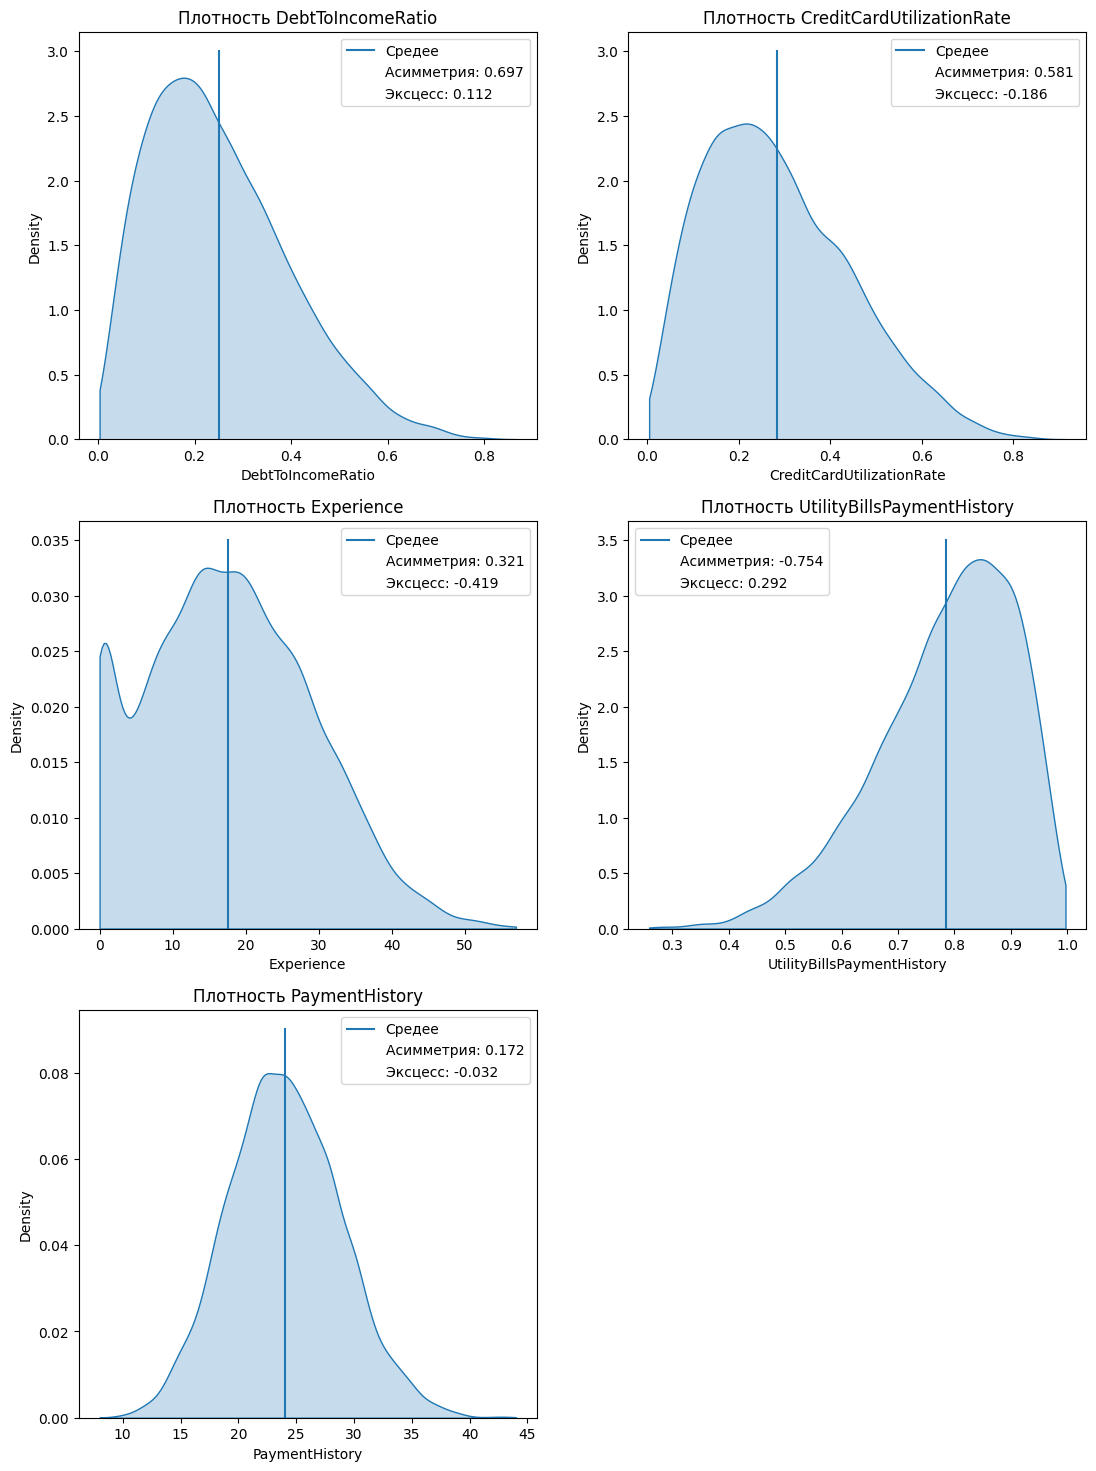

In [2247]:
cols = ['DebtToIncomeRatio', 'CreditCardUtilizationRate', 'Experience', 'UtilityBillsPaymentHistory', 'PaymentHistory']
show_distributions(tf_train_data, cols)

In [2248]:
# def transform_train_and_test():
#   tf_train_data.assign(temp_f=transform(tf_train_data))
#   tf_test_data.assign(temp_f=transform(tf_test_data))
#   tf_train_data.drop(columns=[orig_col], inplace=True)
#   tf_test_data.drop(columns=[orig_col], inplace=True)

In [2249]:
# orig_col = 'BankruptcyHistory'
# tf_col = orig_col + 'Tf'
# def transform(df):
#   df[tf_col] = df[orig_col]
#   df[tf_col] = boxcox_transform(df[tf_col] + 0.2, -1.2)
#   # df[tf_col] = -df[tf_col] + df[tf_col].max() + 1e-6
#   # df[tf_col] = np.log(df[tf_col] + 1e-6)

# transform(test_df)
# compare_distribution(test_df, orig_col, tf_col)
# show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

#### Позитивные преобразования

Преобразования признаков MonthlyIncome, CreditScore, BasePlusActualInterestRate, TotalDebtToIncomeRatio, MonthlyLoanPayment, TotalAssets, LengthOfCreditHistory,TotalLiabilities, NumberOfCreditInquiries, NumberOfDependents, NumberOfOpenCreditLines улучшили показатели метрик линейной регрессиии.


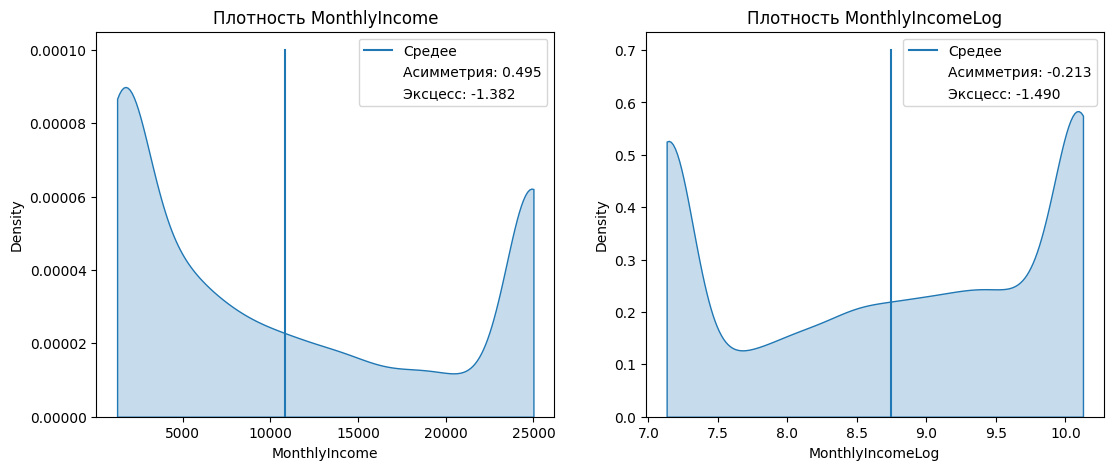

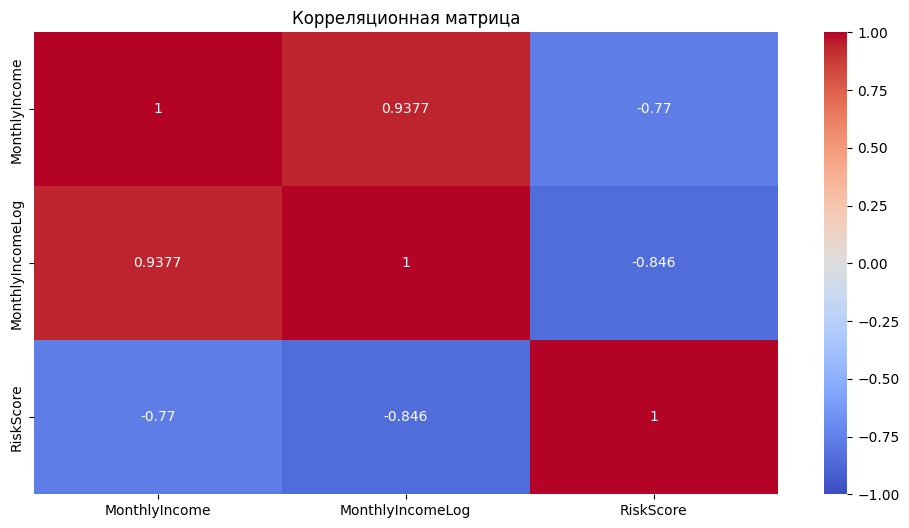

In [2250]:
orig_col = 'MonthlyIncome'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2251]:
def transform_train_and_test():
  tf_train_data.assign(temp_f=transform(tf_train_data))
  tf_test_data.assign(temp_f=transform(tf_test_data))
  tf_train_data.drop(columns=[orig_col], inplace=True)
  tf_test_data.drop(columns=[orig_col], inplace=True)

In [2252]:
transform_train_and_test()

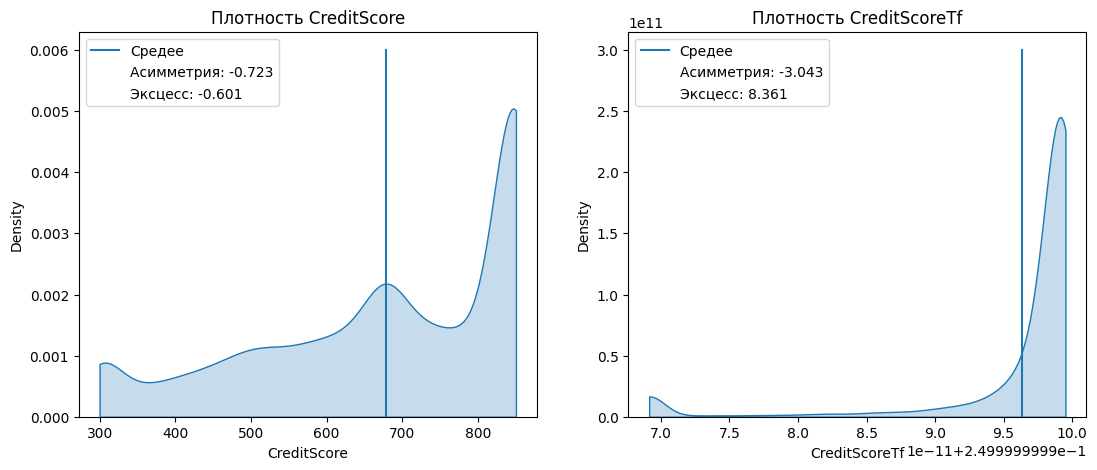

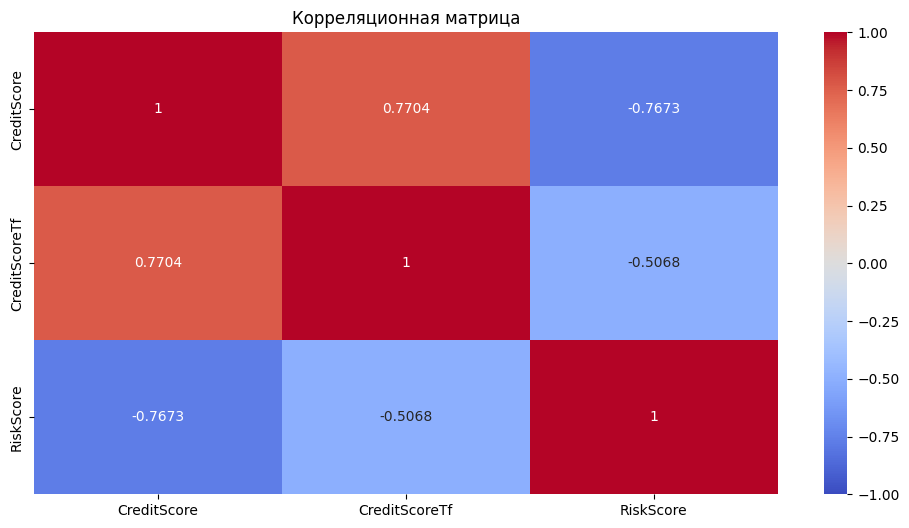

In [2253]:
orig_col = 'CreditScore'
tf_col = orig_col + 'Tf'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = boxcox_transform(df[tf_col], -4.)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

Корреляция после преобразования упала, а ассиметрия и эксцесс выросли по модулю, но тем не менее метрики модели на преобразованном CreditScore показывают лучший результат. Вероятно, это связано с тем, что преобразованный CreditScore меньше коррелирует с другими признаками, чем исходный.

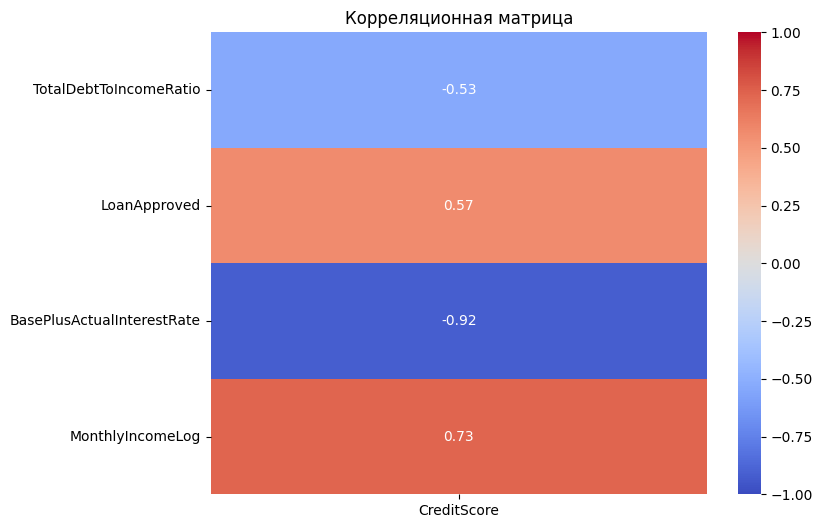

In [2254]:
show_corr_column(tf_train_data, 'CreditScore', annot=True, min_corr=0.3)

In [2255]:
transform_train_and_test()

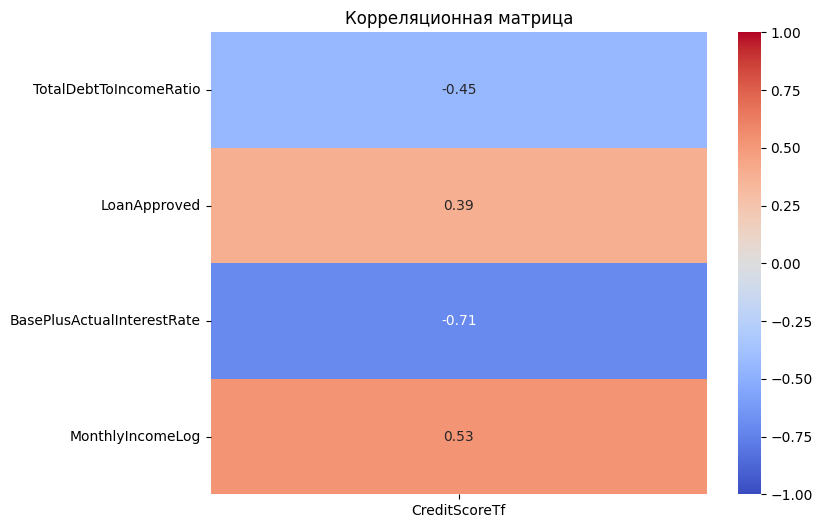

In [2256]:
show_corr_column(tf_train_data, 'CreditScoreTf', annot=True, min_corr=0.3)

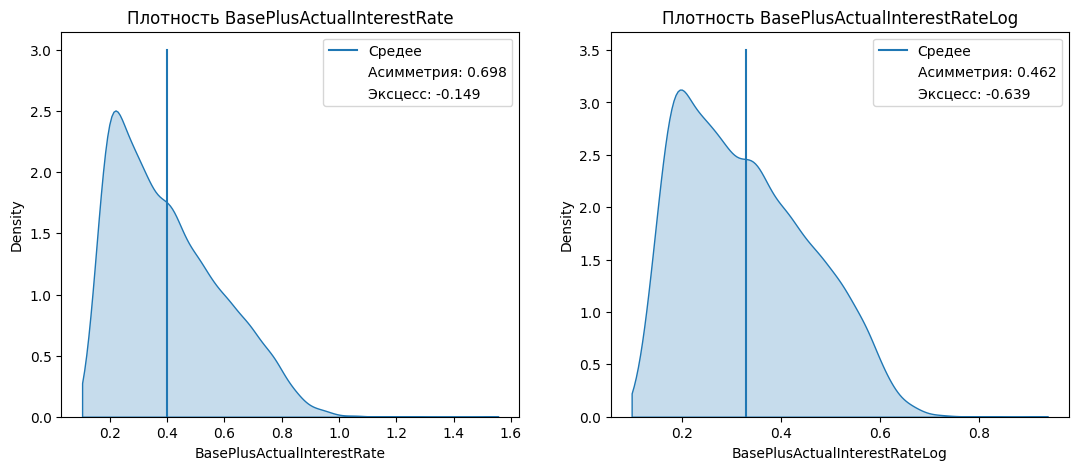

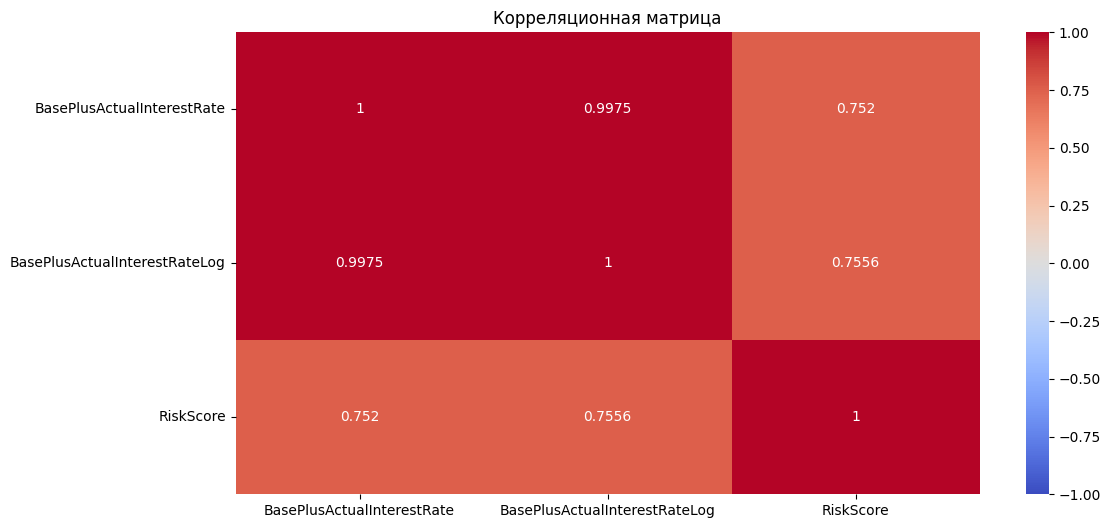

In [2257]:
orig_col = 'BasePlusActualInterestRate'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2258]:
transform_train_and_test()

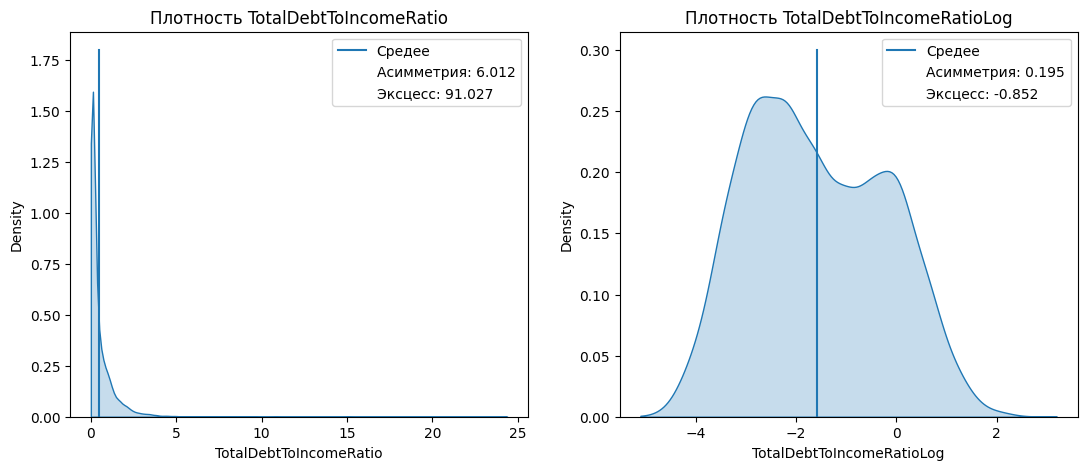

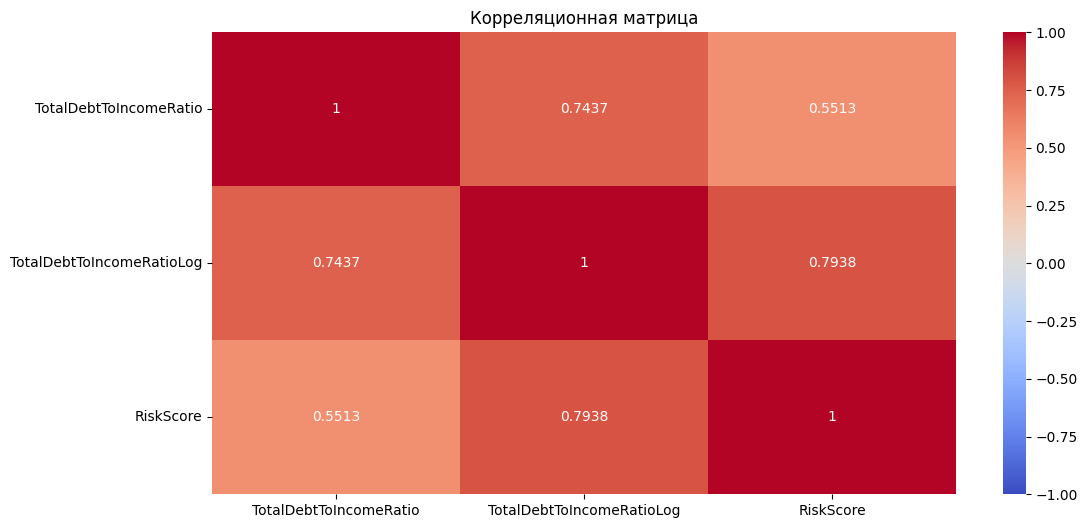

In [2259]:
orig_col = 'TotalDebtToIncomeRatio'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[orig_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2260]:
transform_train_and_test()

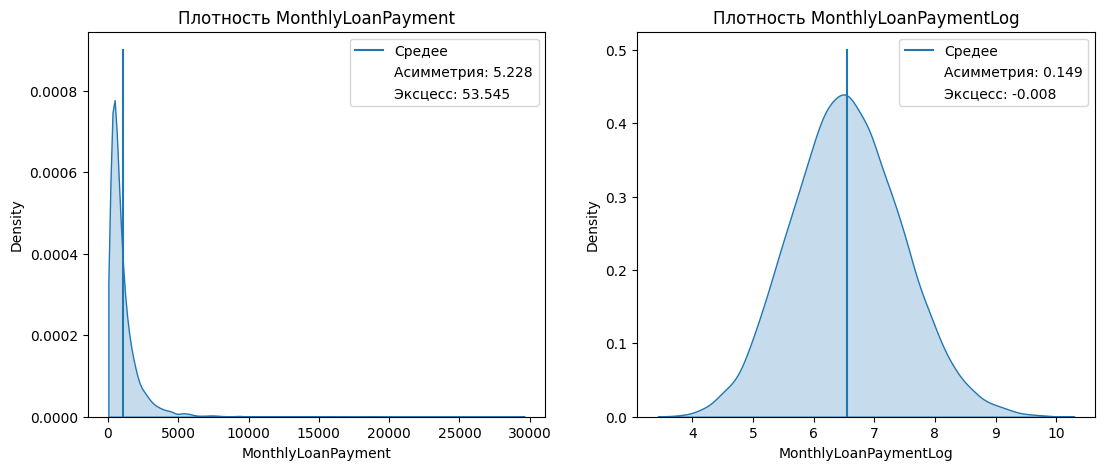

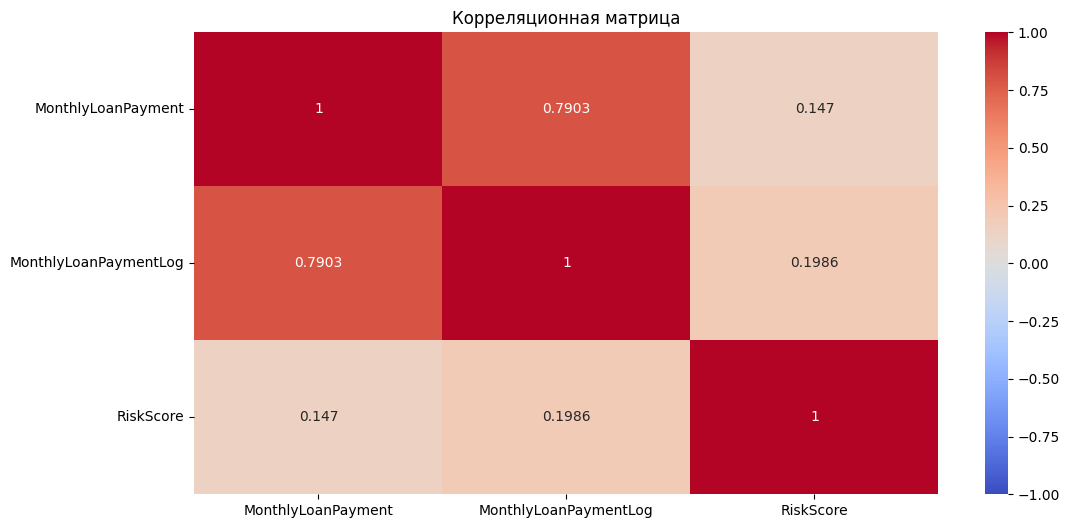

In [2261]:
orig_col = 'MonthlyLoanPayment'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log1p(df[orig_col])

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2262]:
transform_train_and_test()

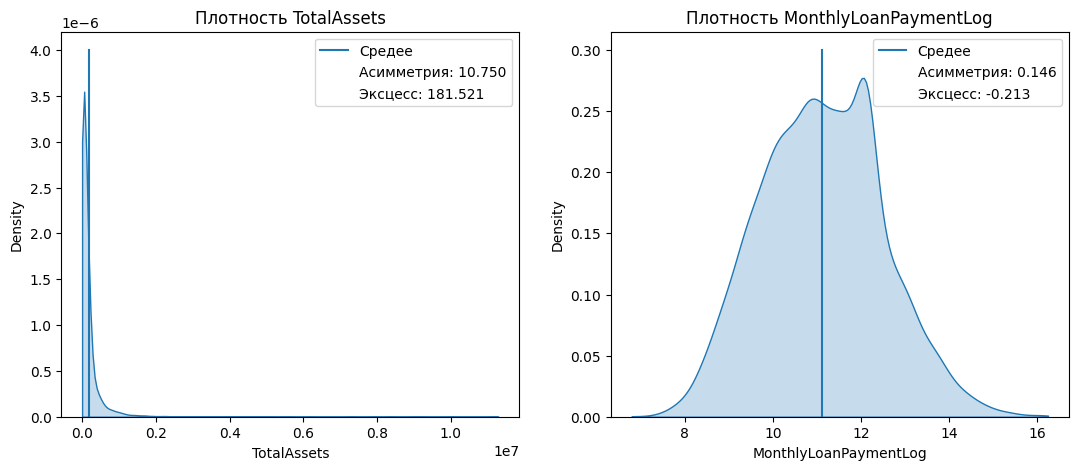

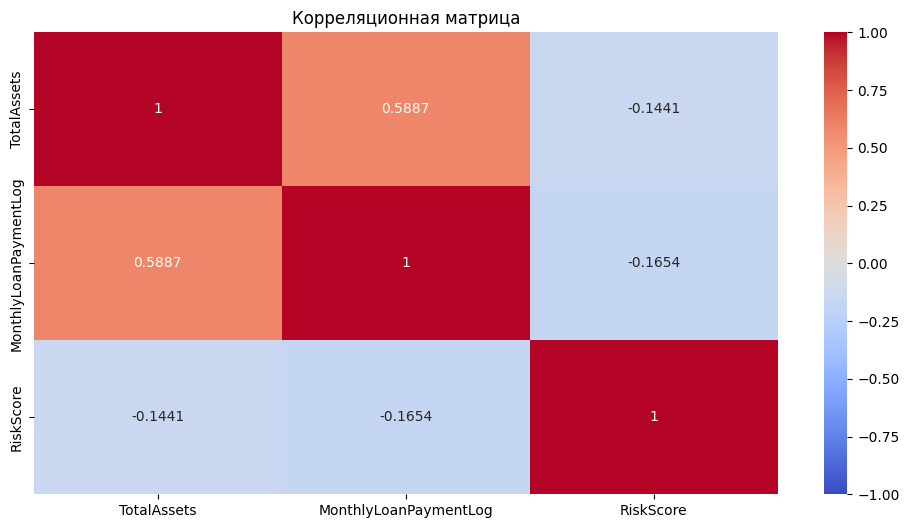

In [2263]:
orig_col = 'TotalAssets'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log1p(df[orig_col])

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2264]:
transform_train_and_test()

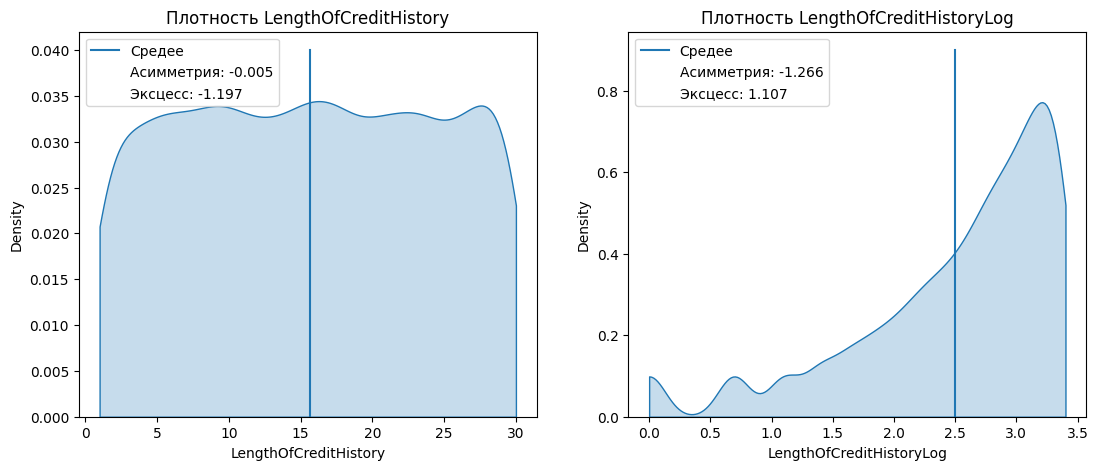

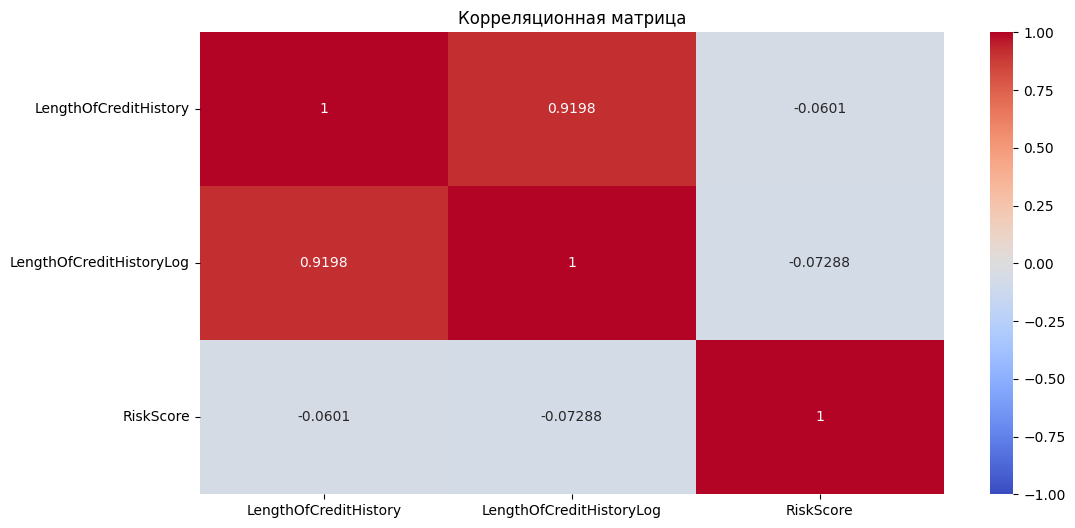

In [2265]:
orig_col = 'LengthOfCreditHistory'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-9)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2266]:
transform_train_and_test()

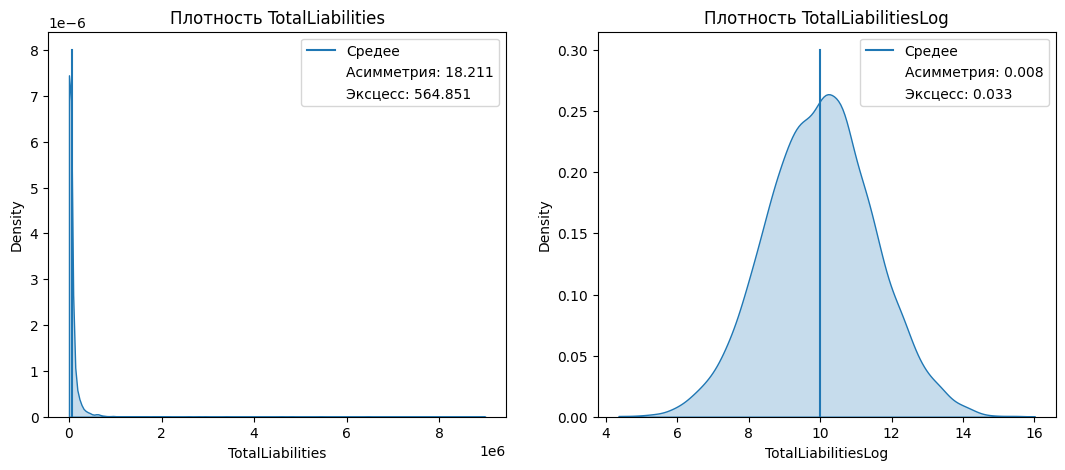

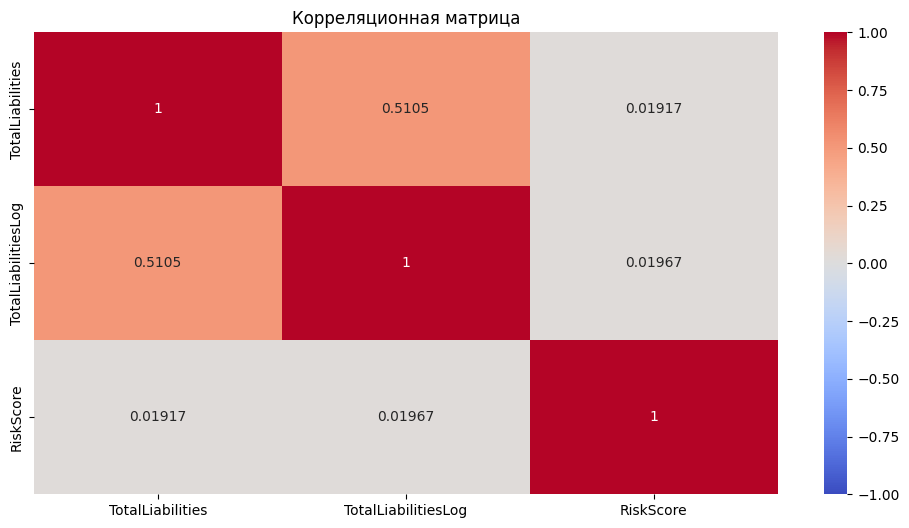

In [2267]:
orig_col = 'TotalLiabilities'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2268]:
transform_train_and_test()

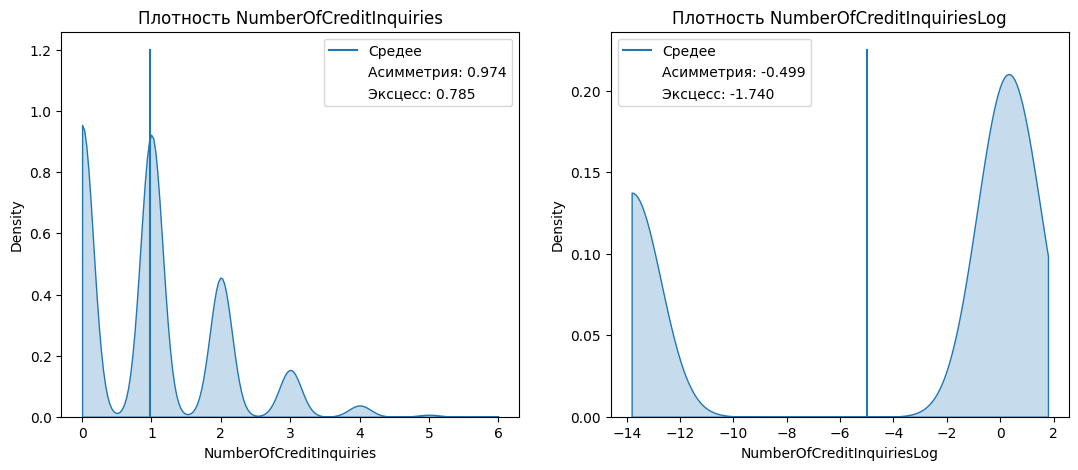

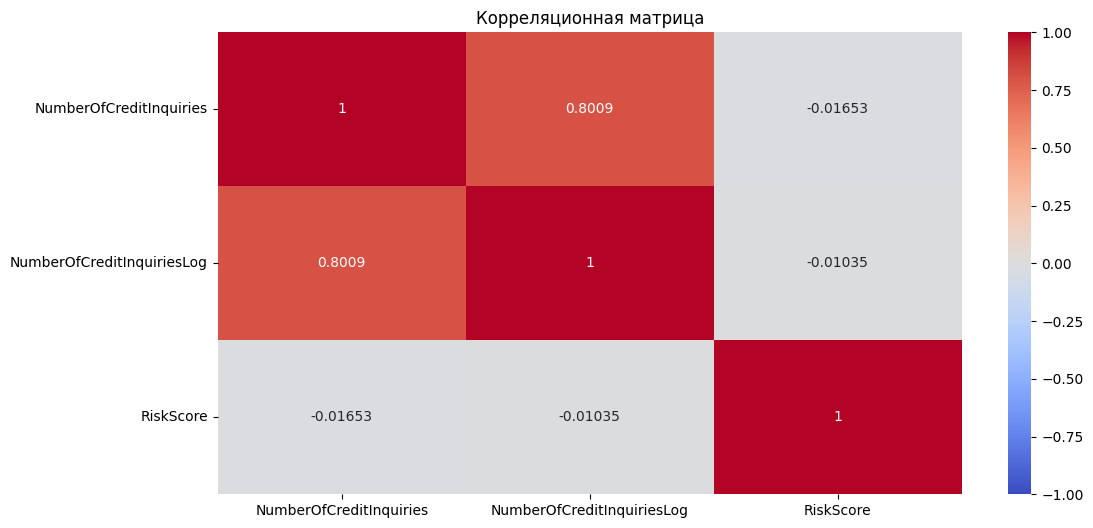

In [2269]:
orig_col = 'NumberOfCreditInquiries'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2270]:
transform_train_and_test()

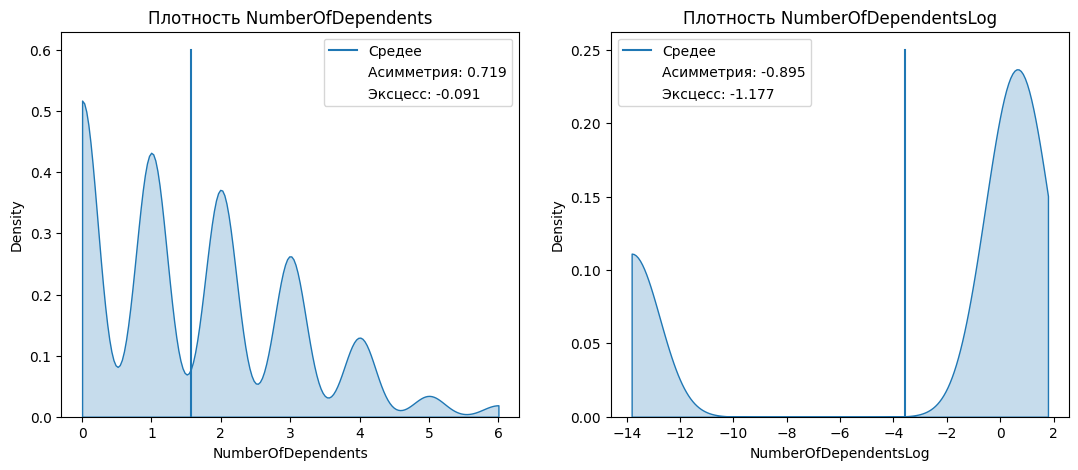

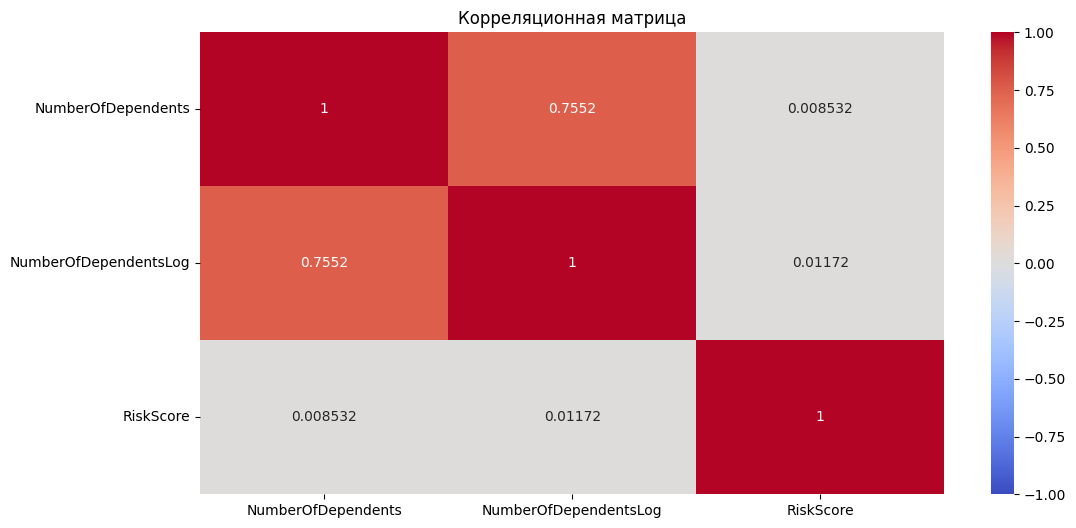

In [2271]:
orig_col = 'NumberOfDependents'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2272]:
transform_train_and_test()

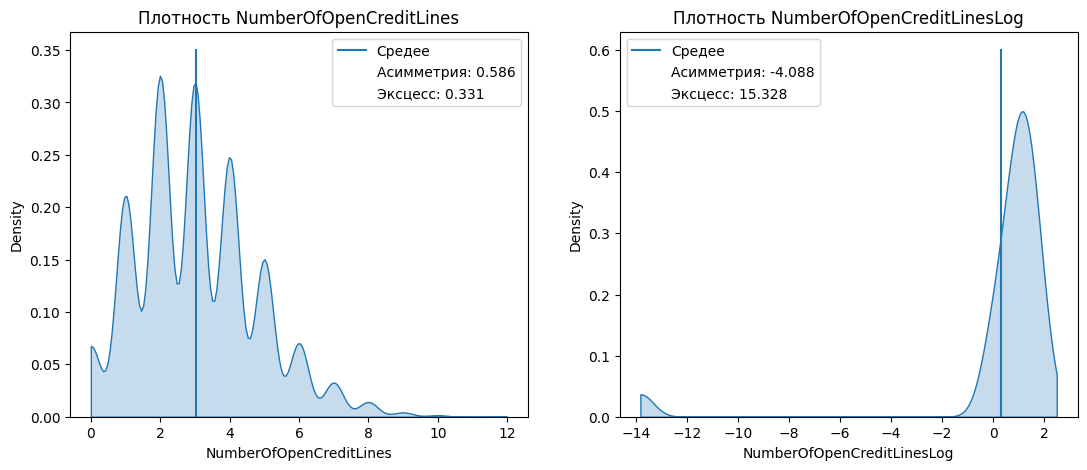

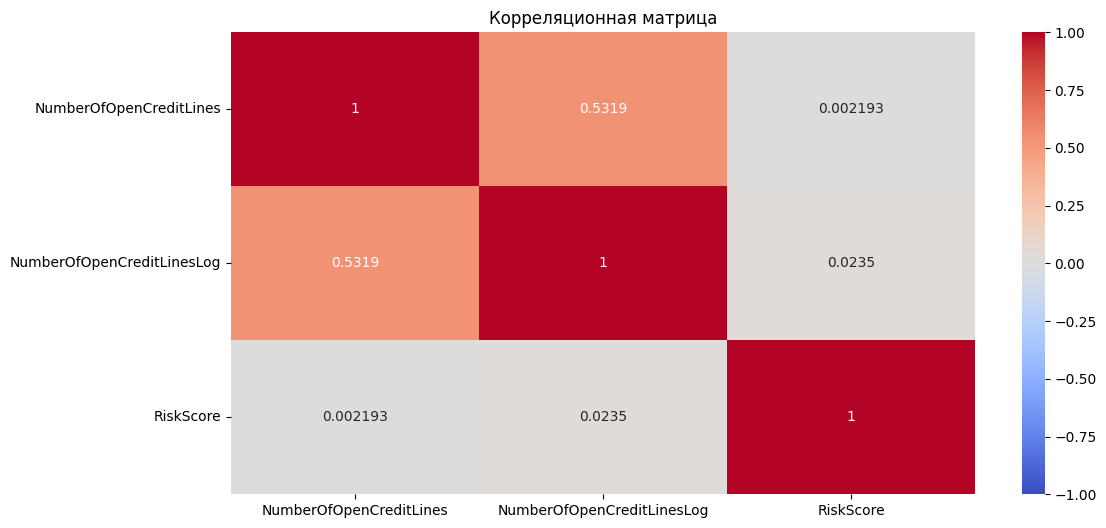

In [2273]:
orig_col = 'NumberOfOpenCreditLines'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

In [2274]:
transform_train_and_test()

#### Негативные преобразования

Преобразования признаков LoanAmount, MonthlyDebtPayments, CheckingAccountBalance, SavingsAccountBalance привели их распределения к более "нормальному" виду, но метрики линейной регрессии при этом ухудшились.

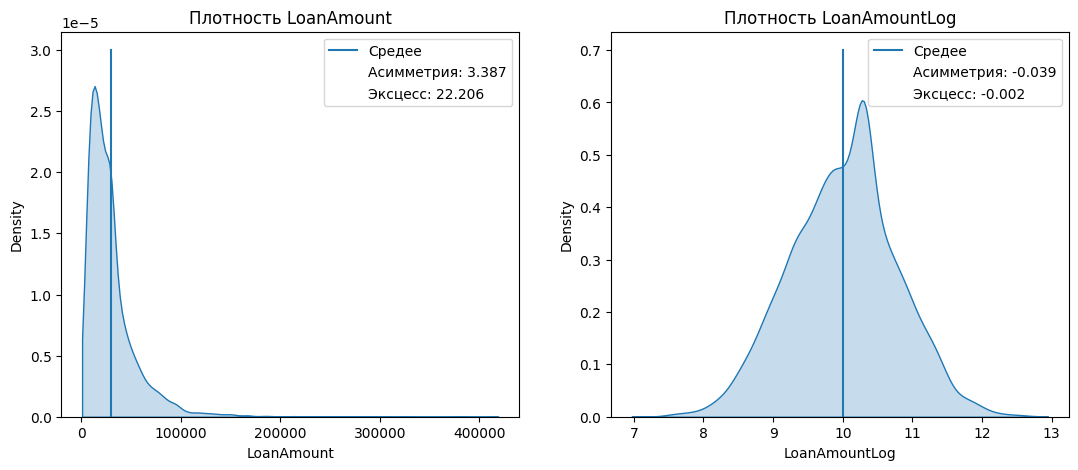

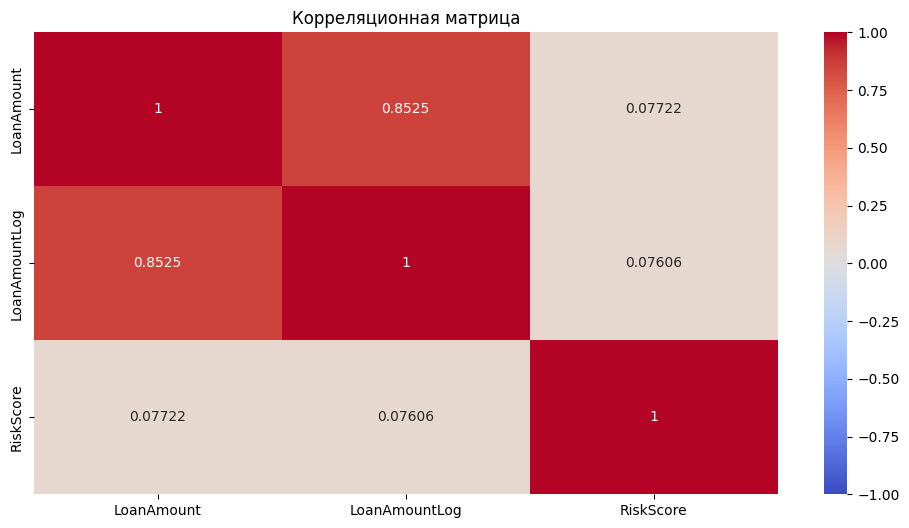

In [2275]:
orig_col = 'LoanAmount'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[orig_col])

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

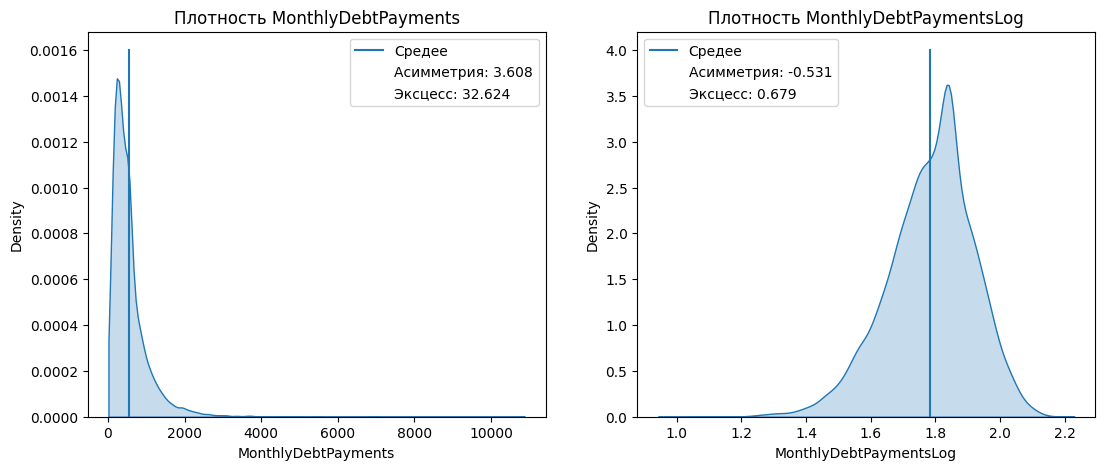

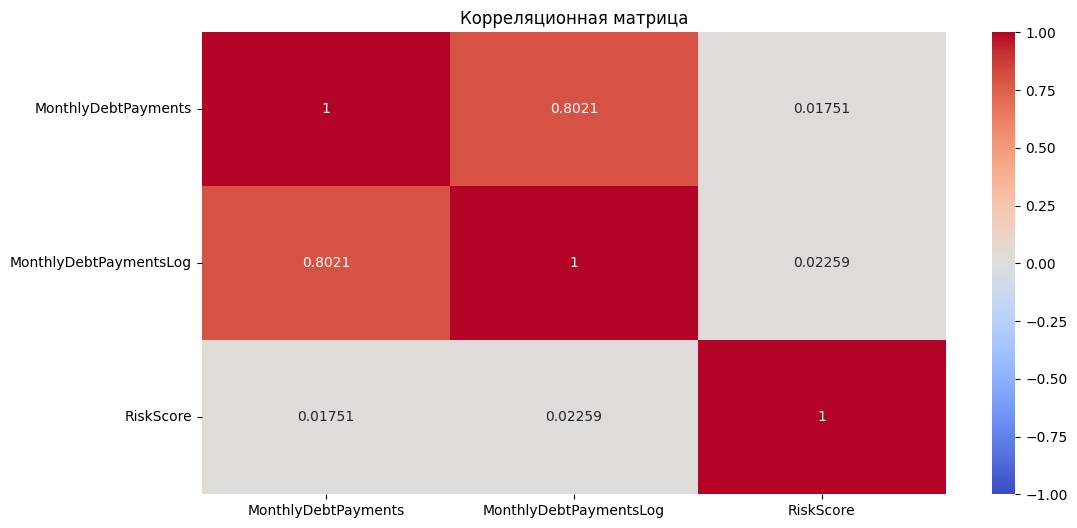

In [2276]:
orig_col = 'MonthlyDebtPayments'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(np.log(df[tf_col]))

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

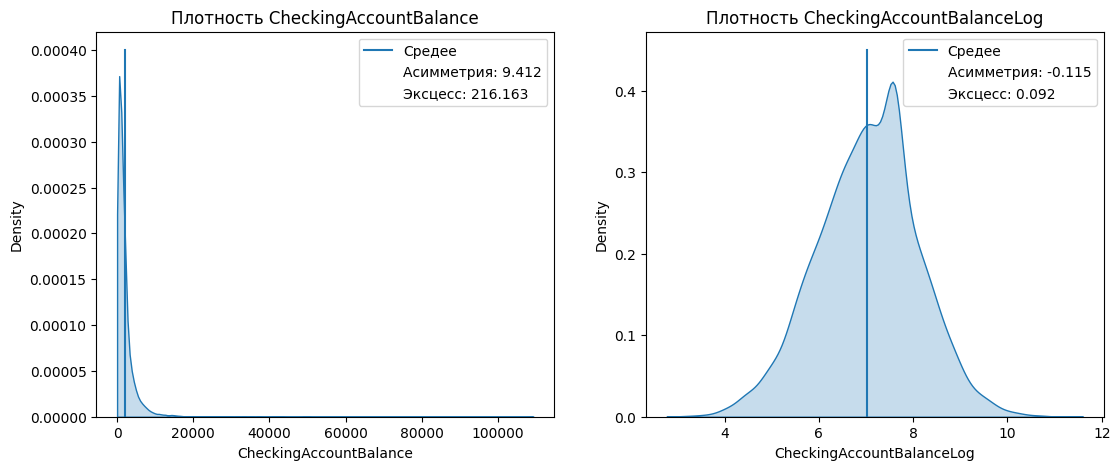

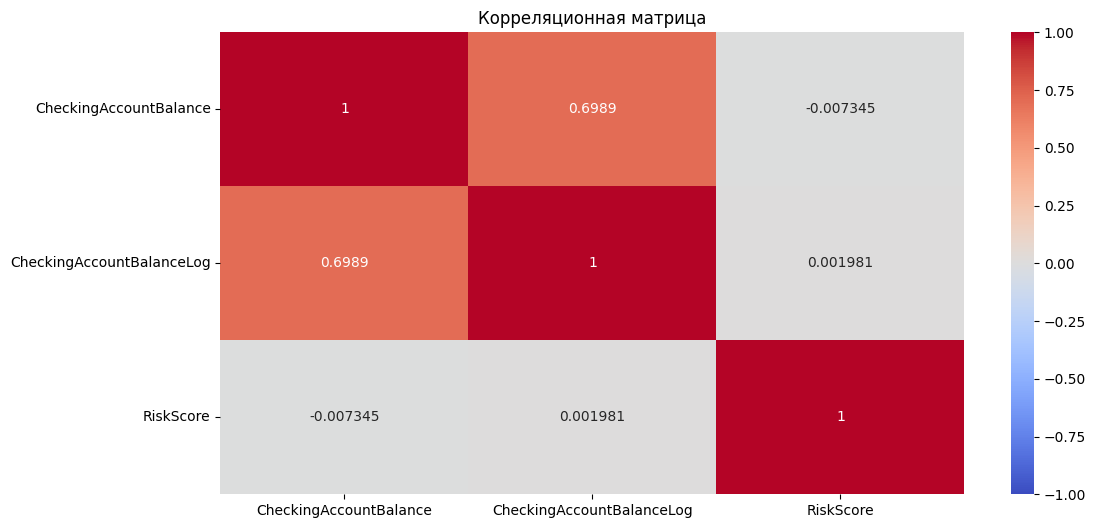

In [2277]:
orig_col = 'CheckingAccountBalance'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

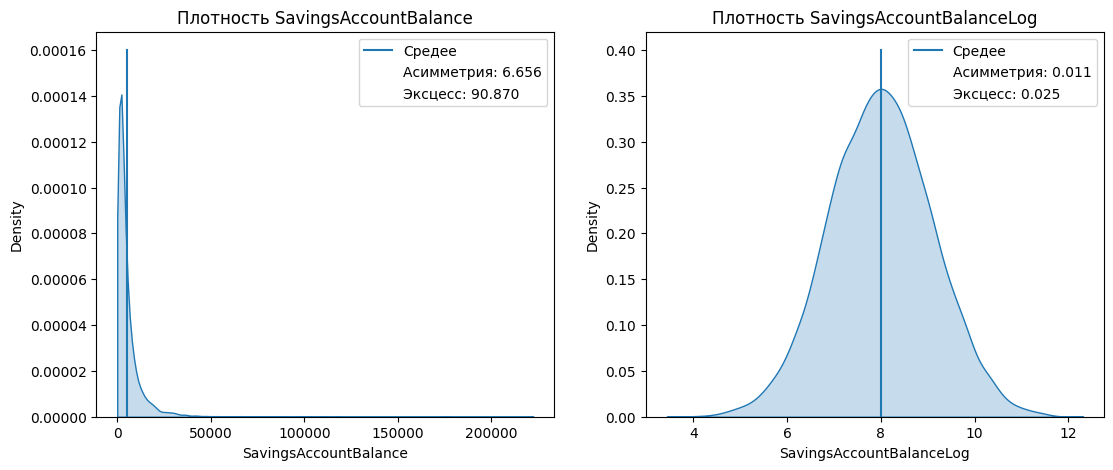

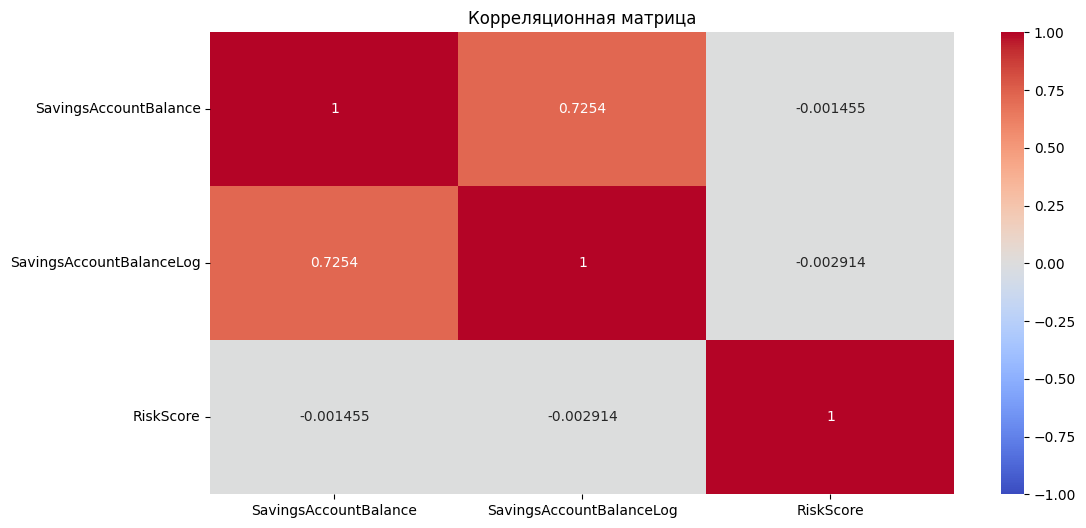

In [2278]:
orig_col = 'SavingsAccountBalance'
tf_col = orig_col + 'Log'
def transform(df):
  df[tf_col] = df[orig_col]
  df[tf_col] = np.log(df[tf_col] + 1e-6)

transform(test_df)
compare_distribution(test_df, orig_col, tf_col)
show_corr_matrix(test_df[[orig_col, tf_col, 'RiskScore']], annot=True, dropTarget=False, fmt='.4g')

#### Неудавшиеся преобразования

Признаки LoanApproved, BankruptcyHistory и PreviousLoanDefaults имеют только два значения, поэтому их невозможно преобразовать.
Признаки LoanDuration и JobTenure не удалось преобразовать так, чтобы показатели распределения или корреляций улучшились.

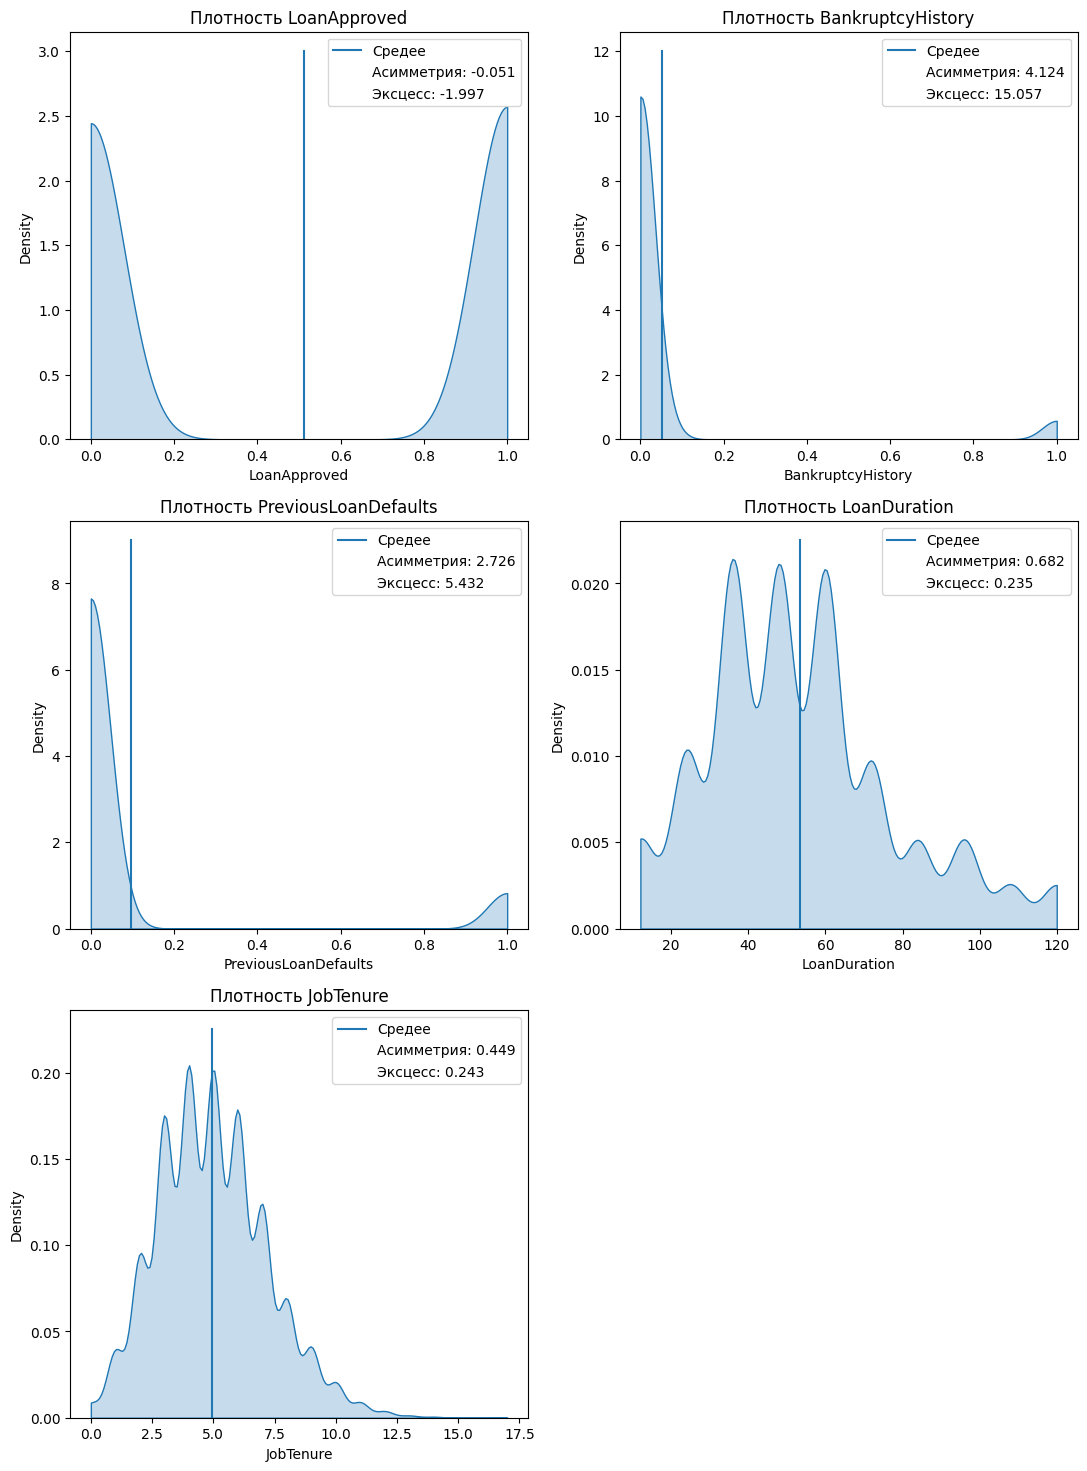

In [2279]:
cols = ['LoanApproved', 'BankruptcyHistory', 'PreviousLoanDefaults', 'LoanDuration', 'JobTenure']
show_distributions(tf_train_data, cols)

# Алгоритмы

### Нормализация

In [2280]:
class MinMaxScaler:

  def __init__(self):
    self.mn = 0
    self.mx = 1

  def fit(self, values : np.ndarray):
    self.mn = np.min(values, axis=0)
    self.mx = np.max(values, axis=0)

  def transform(self, values : np.ndarray):
    return (values - self.mn) / (self.mx - self.mn)

  def fit_transform(self, values : np.ndarray):
    self.fit(values)
    return self.transform(values)

In [2281]:
class ZScoreScaler:

  def __init__(self):
    self.mean = 0
    self.std = 1

  def fit(self, values : np.ndarray):
    self.mean = np.mean(values, axis=0)
    self.std = np.std(values, axis=0, ddof=0)

  def transform(self, values : np.ndarray):
    return (values - self.mean) / (self.std)

  def fit_transform(self, values : np.ndarray):
    self.fit(values)
    return self.transform(values)

In [2282]:
df = pd.DataFrame({'Test1': [1, 2, 3, 4, 5], 'Test2': [1, 10, 100, 1000, 10000]})

In [2283]:
scaler = MinMaxScaler()
scaler.fit_transform(df.values)

array([[0.00000000e+00, 0.00000000e+00],
       [2.50000000e-01, 9.00090009e-04],
       [5.00000000e-01, 9.90099010e-03],
       [7.50000000e-01, 9.99099910e-02],
       [1.00000000e+00, 1.00000000e+00]])

In [2284]:
scaler = sk.preprocessing.MinMaxScaler()
scaler.fit_transform(df.values)

array([[0.00000000e+00, 0.00000000e+00],
       [2.50000000e-01, 9.00090009e-04],
       [5.00000000e-01, 9.90099010e-03],
       [7.50000000e-01, 9.99099910e-02],
       [1.00000000e+00, 1.00000000e+00]])

In [2285]:
scaler = ZScoreScaler()
scaler.fit_transform(df.values)

array([[-1.41421356, -0.56853297],
       [-0.70710678, -0.56622936],
       [ 0.        , -0.54319317],
       [ 0.70710678, -0.31283135],
       [ 1.41421356,  1.99078685]])

In [2286]:
scaler = sk.preprocessing.StandardScaler()
scaler.fit_transform(df.values)

array([[-1.41421356, -0.56853297],
       [-0.70710678, -0.56622936],
       [ 0.        , -0.54319317],
       [ 0.70710678, -0.31283135],
       [ 1.41421356,  1.99078685]])

### Метрики

In [2287]:
def mean_squared_error(true_vector, pred_vector):
  loss = ((true_vector - pred_vector) ** 2)
  return loss.sum() / len(true_vector)

def mean_absolute_error(true_vector, pred_vector):
  loss = np.abs((true_vector - pred_vector))
  return loss.sum() / len(true_vector)

def mean_absolute_percentage_error(true_vector, pred_vector):
  loss = np.abs((true_vector - pred_vector) / true_vector)
  return loss.sum() / len(true_vector)

def r2_score(true_vector, pred_vector):
  mean = np.mean(true_vector)
  numer = ((true_vector - pred_vector) ** 2).sum()
  denom = ((true_vector - mean) ** 2).sum()
  return 1 - numer / denom

In [2288]:
y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

print("SK Mean squared error:", sk.metrics.mean_squared_error(y_true, y_pred))
print("My Mean squared error:", mean_squared_error(y_true, y_pred))
print("SK Mean absolute error:", sk.metrics.mean_absolute_error(y_true, y_pred))
print("My Mean absolute error:", mean_absolute_error(y_true, y_pred))
print("SK Mean absolute percentage error:", sk.metrics.mean_absolute_percentage_error(y_true, y_pred))
print("My Mean absolute percentage error:", mean_absolute_percentage_error(y_true, y_pred))
print("SK R2 score:", sk.metrics.r2_score(y_true, y_pred))
print("My R2 score:", r2_score(y_true, y_pred))

SK Mean squared error: 0.375
My Mean squared error: 0.375
SK Mean absolute error: 0.5
My Mean absolute error: 0.5
SK Mean absolute percentage error: 0.3273809523809524
My Mean absolute percentage error: 0.3273809523809524
SK R2 score: 0.9486081370449679
My R2 score: 0.9486081370449679


### Линейная регрессия

In [2289]:
class LinearRegression:

  def fit(self, features, target):
    feat = self._intercept(features)
    target = target.reshape((feat.shape[0], 1))
    t_feat = np.transpose(feat)
    sym = np.matmul(t_feat, feat)
    inv = np.linalg.inv(sym)
    self.weights = np.matmul(np.matmul(inv, t_feat), target)

  def predict(self, features):
    feat = self._intercept(features)
    return np.matmul(feat, self.weights).reshape(-1)

  @staticmethod
  def _intercept(featutes):
    col = np.ones(shape=(featutes.shape[0], 1))
    return np.hstack((col, featutes))

In [ ]:
class GDLinearRegression(LinearRegression):

  def __init__(self,
               learn_coef = 0.01,
               learn_pow = 0.25,
               max_iter = 1000,
               regularization: Literal['l1', 'l2', 'elasticNet', None] = None,
               reg_coef = 0.0001,
               net_l1_ratio = 0.15,
               random_state = None):
    if ((net_l1_ratio < 0) | (net_l1_ratio > 1)):
      raise ValueError('net_l1_ratio must be in [0;1]')
    if (random_state == None):
      random_state = round(time.time())

    self.learn_coef = learn_coef
    self.learn_pow = learn_pow
    self.max_iter = max_iter
    self.regularization = regularization
    self.reg_coef = reg_coef
    self.net_l1_ratio = net_l1_ratio
    self.rng = np.random.default_rng(seed=random_state)
    np.random.seed(random_state)

  def fit(self, features, target):
    feat = self._intercept(features)
    target = target.reshape((feat.shape[0], 1))
    iter = 0
    feat_cnt = feat.shape[1]
    w0 = np.zeros(shape=(feat_cnt, 1))
    w1 = self.rng.uniform(low=-1, high=1, size=feat_cnt).reshape((feat_cnt, 1))

    while iter < self.max_iter:
      iter += 1
      w0 = w1
      coef = self._get_learning_rate(iter)
      grad = self._get_gradient(w0, feat, target)
      reg_grad = self._get_reg_gradient(w0)
      w1 = w0 - coef * grad - reg_grad

    self.weights = w1

  def _get_learning_rate(self, k):
    return self.learn_coef / (k ** self.learn_pow)

  def _get_gradient(self, w, feat, target):
    pred = np.matmul(feat, w)
    return 2 / feat.shape[0] * feat.transpose().dot(pred - target)

  def _get_reg_gradient(self, w):
    match self.regularization:
      case 'l1':
        return self.reg_coef * np.sign(w)
      case 'l2':
        return self.reg_coef * w
      case 'elasticNet':
          return self.reg_coef * (self.net_l1_ratio * np.sign(w) + (1 - self.net_l1_ratio) * w)
      case _:
          return 0


In [2291]:
class SGDLinearRegression(GDLinearRegression):

  def __init__(self,
               learn_coef = 0.1,
               learn_pow = 0.1,
               max_iter = 10000,
               regularization: Literal['l1', 'l2', 'elasticNet', None] = None,
               reg_coef = 0.0001,
               net_l1_ratio = 0.15,
               random_state = None):
    super().__init__(learn_coef, learn_pow, max_iter, regularization, reg_coef, net_l1_ratio, random_state)

  def _get_gradient(self, w, feat, target):
    chosen_row = np.random.randint(0, feat.shape[0])
    pred = np.dot(feat[chosen_row], w)
    return 2 / feat.shape[0] * feat[chosen_row].reshape(-1, 1) * (pred - target[chosen_row])

### Кросс-валидация

In [ ]:
def get_k_fold_score(model, x, y, fold_count, metrics=[mean_squared_error], random_state=None):
  if (fold_count <= 1):
    raise ValueError('fold count must be greater than 1')
  if (random_state == None):
      random_state = round(time.time())
  indexes = np.arange(len(y))
  np.random.seed(random_state)
  np.random.shuffle(indexes)
  folds = np.array_split(indexes, fold_count)
  scores = np.ndarray((fold_count, len(metrics)))
  for i in range(fold_count):
    train_x = np.delete(x, folds[i], axis=0)
    train_y = np.delete(y, folds[i], axis=0)
    test_x = x[folds[i]]
    test_y = y[folds[i]]

    model.fit(train_x, train_y)
    pred = model.predict(test_x)

    for j in range(len(metrics)):
      scores[i][j] = metrics[j](test_y, pred)

  return scores.mean(axis=0)

def get_leave_one_out_score(model, x, y, metrics=[mean_squared_error], random_state=None):
  return get_k_fold_score(model, x, y, len(y), metrics=metrics, random_state=random_state)

# Сравнение регрессий

In [2295]:
x = tf_train_data.drop(columns='RiskScore').values
y = tf_train_data['RiskScore'].values
scaler = sk.preprocessing.StandardScaler()
x = scaler.fit_transform(x)

In [2296]:
def compare_models(models, titles, fold_cnt=5, metrics=[mean_squared_error, r2_score]):
  scores = np.ndarray((len(titles),len(metrics)))
  times = np.ndarray(len(titles))

  for i in range(len(titles)):
    start = time.time()
    scores[i] = get_k_fold_score(models[i], x, y, fold_cnt, metrics=metrics, random_state=777)
    times[i] = round(1000 * (time.time() - start))

  return pd.DataFrame({'CV MSE': scores[:,0], 'CV R2': scores[:,1], 'Time, ms': times}, index=titles)

In [ ]:
my_predictor = LinearRegression()
sk_predictor = sk.linear_model.LinearRegression()

models = [my_predictor, sk_predictor]
titles = ['My LinearRegression', 'SK LinearRegression']

compare_models(models, titles)

CV MSE     CV R2  Time, ms
My LinearRegression  15.618941  0.947383      43.0
SK LinearRegression  15.618941  0.947383     199.0

In [ ]:
my_gd_predictor = GDLinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, random_state=777)
my_sgd_predictor = SGDLinearRegression(learn_coef=10, learn_pow=0.15, max_iter=10000, random_state=777)
sk_predictor = sk.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=10000, random_state=777, penalty=None)

models = [my_gd_predictor, my_sgd_predictor, sk_predictor]
titles = ['My GDLinearRegression', 'My SGDLinearRegression', 'SK SGDLinearRegression']

compare_models(models, titles)

CV MSE     CV R2  Time, ms
My GDLinearRegression   18.514434  0.937629    1371.0
My SGDLinearRegression  17.109113  0.942365     882.0
SK SGDLinearRegression  15.684367  0.947163     267.0

In [2299]:
my_gd_predictor = GDLinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, random_state=777, regularization='l1', reg_coef=1e-6)
my_sgd_predictor = SGDLinearRegression(learn_coef=10, learn_pow=0.15, max_iter=10000, random_state=777, regularization='l1', reg_coef=1e-6)
sk_predictor = sk.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=10000, random_state=777, penalty='l1', alpha=1e-6)

models = [my_gd_predictor, my_sgd_predictor, sk_predictor]
titles = ['My GDLinearRegressionL1', 'My SGDLinearRegressionL1', 'SK SGDLinearRegressionL1']

compare_models(models, titles)

CV MSE     CV R2  Time, ms
My GDLinearRegressionL1   18.514360  0.937629    1423.0
My SGDLinearRegressionL1  17.105870  0.942376     892.0
SK SGDLinearRegressionL1  15.684227  0.947164     883.0

In [2300]:
my_gd_predictor = GDLinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, random_state=777, regularization='l2', reg_coef=1e-6)
my_sgd_predictor = SGDLinearRegression(learn_coef=10, learn_pow=0.15, max_iter=10000, random_state=777, regularization='l2', reg_coef=1e-6)
sk_predictor = sk.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=10000, random_state=777, penalty='l2', alpha=1e-6)

models = [my_gd_predictor, my_sgd_predictor, sk_predictor]
titles = ['My GDLinearRegressionL2', 'My SGDLinearRegressionL2', 'SK SGDLinearRegressionL2']

compare_models(models, titles)

CV MSE     CV R2  Time, ms
My GDLinearRegressionL2   18.527603  0.937584    1873.0
My SGDLinearRegressionL2  17.142719  0.942253     976.0
SK SGDLinearRegressionL2  15.684368  0.947163     273.0

In [2301]:
my_gd_predictor = GDLinearRegression(learn_coef=0.01, learn_pow=0.25, max_iter=1000, random_state=777, regularization='elasticNet', reg_coef=1e-6)
my_sgd_predictor = SGDLinearRegression(learn_coef=10, learn_pow=0.15, max_iter=10000, random_state=777, regularization='elasticNet', reg_coef=1e-6)
sk_predictor = sk.linear_model.SGDRegressor(eta0=0.01, power_t=0.25, max_iter=10000, random_state=777, penalty='elasticnet', alpha=1e-6)

models = [my_gd_predictor, my_sgd_predictor, sk_predictor]
titles = ['My GDLinearRegressionL2', 'My SGDLinearRegressionL2', 'SK SGDLinearRegressionL2']

compare_models(models, titles)

CV MSE     CV R2  Time, ms
My GDLinearRegressionL2   18.525599  0.937591    1400.0
My SGDLinearRegressionL2  17.136511  0.942274    1135.0
SK SGDLinearRegressionL2  15.684346  0.947164     467.0

# Финальное предсказание

In [2302]:
predictor = LinearRegression()

x = tf_train_data.drop(columns='RiskScore').values
y = tf_train_data['RiskScore'].values
t = tf_test_data.drop(columns='ID').values

scaler = ZScoreScaler()
x = scaler.fit_transform(x)
t = scaler.transform(t)

predictor.fit(x, y)
pred = predictor.predict(t)

df = pd.DataFrame({'ID': np.arange(0, len(pred)), 'RiskScore': pred.reshape(-1)})
df.to_csv('res.csv', index=False)